In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Loading functions
import os
import time
from monai.data import DataLoader, decollate_batch


import torch
import torch.nn.parallel

from src.get_data import CustomDataset, CustomDatasetSeg
import numpy as np
from scipy import ndimage
from types import SimpleNamespace
import wandb
import logging

#####
import json
import shutil
import tempfile

import matplotlib.pyplot as plt
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
    MapTransform,
    Transform,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data

# from monai.data import decollate_batch
from functools import partial
from src.custom_transforms import (ConvertToMultiChannelBasedOnN_Froi, 
                                   ConvertToMultiChannelBasedOnAnotatedInfiltration, 
                                   masked, ConvertToMultiChannelBasedOnBratsClassesdI)

#### Trasnformaciones

In [3]:
roi = (128, 128, 128) # (220, 220, 155) (128, 128, 64)
source_k="label"
train_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        # ConvertToMultiChannelBasedOnN_Froi(keys="label"),
        # masked(keys="image"),
        ConvertToMultiChannelBasedOnAnotatedInfiltration(keys="label"),
        # ConvertToMultiChannelBasedOnBratsClassesdI(keys="label"),
        transforms.CropForegroundd(
            keys=["image", "label"],
            source_key=source_k,
            k_divisible=[roi[0], roi[1], roi[2]],
        ),
        transforms.RandSpatialCropd(
            keys=["image", "label"],
            roi_size=[roi[0], roi[1], roi[2]],
            random_size=False,
        ),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        
    ]
)
val_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        # ConvertToMultiChannelBasedOnN_Froi(keys="label"),
        # masked(keys="image"),
        ConvertToMultiChannelBasedOnAnotatedInfiltration(keys="label"),
        # ConvertToMultiChannelBasedOnBratsClassesdI(keys="label"),
        transforms.RandSpatialCropd(
            keys=["image", "label"],
            roi_size=[-1, -1, -1], #[224, 224, 128],
            random_size=False,
        ),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

/home/minigo/anaconda3/envs/monai_env/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## Modelos

In [3]:
######################
# Crear el modelo
######################

### Hyperparameter
roi = (128, 128, 128)  # (128, 128, 128)

# Create Swin transformer
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def define_model(model_path):
    model = SwinUNETR(
        img_size=roi,
        in_channels=11, # 11
        out_channels=2,  # mdificar con edema
        feature_size=48, #48
        drop_rate=0.0,
        attn_drop_rate=0.0,
        dropout_path_rate=0.0,
        use_checkpoint=True,
    )

    loaded_model = torch.load(model_path, map_location=torch.device('cuda:0'), weights_only=False)["state_dict"]

    # Load the state dictionary into the model
    model.load_state_dict(loaded_model)
    return model
    

In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('mlops-team89/Swin_UPENN_10cases/gffqpzjv_best_model:v0', type='model')
artifact_dir = artifact.download()

In [4]:
# Modelo TC+Edema
model1=define_model("artifacts/vtzpbajf_best_model:v0/model.pt") # o9kppyr5
# model1=define_model("artifacts/gffqpzjv_best_model:v0/model.pt") # gffqpzjv 
model1.to(device)
model1.eval()

# Modelo Infitracion+Edema
model2=define_model("artifacts/1dhzmigz_best_model:v0/model.pt") # uixfayrn - rvu24jip
# model2=define_model("artifacts/8exzvcui_best_model:v0/model.pt") # 8exzvcui
model2.to(device)
model2.eval()

/home/minigo/anaconda3/envs/monai_env/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(11, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2): Linear(in_featur

## Crear imagen con ceros para anular canales

In [4]:
import os
import shutil
import nibabel as nib
import numpy as np

# --- Incluimos la función del paso anterior para crear la imagen en negro ---
# (Puedes omitir esta parte si ya tienes la imagen creada)
def create_black_image(reference_path, output_path):
    """Crea una imagen NIfTI de ceros a partir de una referencia."""
    try:
        print(f"Creando imagen en negro de referencia desde: {reference_path}")
        ref_img = nib.load(reference_path)
        
        zero_array = np.zeros(ref_img.shape, dtype=ref_img.get_data_dtype())
        
        black_nifti = nib.nifti1.Nifti1Image(zero_array, ref_img.affine, ref_img.header)
        
        nib.save(black_nifti, output_path)
        print(f"Imagen en negro guardada en: {output_path}")
        return True
    except FileNotFoundError:
        print(f"Error: No se encontró la imagen de referencia en {reference_path}")
        return False
    except Exception as e:
        print(f"Ocurrió un error al crear la imagen en negro: {e}")
        return False

# --- Función principal para reemplazar la modalidad ---
def replace_modality_with_black(dataset_dir, black_image_path, modality_suffix):
    """
    Busca recursivamente en un dataset y reemplaza todos los archivos de una
    modalidad específica con una imagen en negro.

    Args:
        dataset_dir (str): La ruta al directorio raíz del dataset (ej. './images').
        black_image_path (str): La ruta a la imagen .nii.gz de ceros.
        modality_suffix (str): El sufijo del nombre de archivo que identifica la 
                               modalidad a reemplazar (ej. '_FLAIR.nii.gz').
    """
    # --- Verificaciones iniciales ---
    if not os.path.isdir(dataset_dir):
        print(f"Error: El directorio del dataset no existe: {dataset_dir}")
        return

    if not os.path.isfile(black_image_path):
        print(f"Error: La imagen en negro no se encuentra en: {black_image_path}")
        return

    if not modality_suffix:
        print("Error: El sufijo de la modalidad no puede estar vacío.")
        return

    print("--- Iniciando el proceso de reemplazo ---")
    print(f"Directorio a procesar: {dataset_dir}")
    print(f"Modalidad a reemplazar (sufijo): '{modality_suffix}'")
    print(f"Usando imagen de reemplazo: {black_image_path}")
    print("-" * 20)

    # --- Búsqueda y reemplazo ---
    files_replaced_count = 0
    # os.walk recorre todos los directorios y subdirectorios
    for root, dirs, files in os.walk(dataset_dir):
        for filename in files:
            # Comprobamos si el nombre del archivo termina con el sufijo deseado
            if filename.endswith(modality_suffix):
                target_file_path = os.path.join(root, filename)
                
                print(f"Encontrado: {target_file_path}")
                
                try:
                    # shutil.copy SOBREESCRIBE el archivo de destino
                    shutil.copy(black_image_path, target_file_path)
                    print(f"  -> Reemplazado exitosamente.")
                    files_replaced_count += 1
                except Exception as e:
                    print(f"  -> ERROR al reemplazar el archivo: {e}")

    # --- Resumen final ---
    print("-" * 20)
    if files_replaced_count > 0:
        print(f"Proceso completado. Se han reemplazado {files_replaced_count} archivos.")
    else:
        print(f"Proceso completado. No se encontraron archivos con el sufijo '{modality_suffix}'.")


# --- EJEMPLO DE USO ---
if True:

    # ¡ADVERTENCIA IMPORTANTE! 
    # Esta operación SOBREESCRIBE archivos de forma permanente.
    # Se recomienda hacer una copia de seguridad de tu dataset antes de ejecutarla.
    
    # 1. Configura tus rutas
    DATASET_ROOT_DIR = "Dataset/Dataset_30_6/test_6_1out"  # Directorio raíz que contiene 'images' y 'labels'
    IMAGES_DIR = os.path.join(DATASET_ROOT_DIR, "images")
    
    # Ruta para guardar la imagen en negro temporal.
    # Se crea una vez y luego se reutiliza.
    BLACK_IMAGE_OUTPUT_PATH = os.path.join(DATASET_ROOT_DIR, "black_image.nii.gz")

    # Ruta a una imagen cualquiera de tu dataset para usarla como referencia de tamaño/espacio.
    # ¡Asegúrate de que esta ruta sea correcta!
    REFERENCE_IMAGE_FOR_BLACK = os.path.join(
        IMAGES_DIR, 
        "images_structural/UPENN-GBM-00055_11/UPENN-GBM-00055_11_T1.nii.gz"
    )

    # 2. Crea la imagen en negro si no existe
    if not os.path.exists(BLACK_IMAGE_OUTPUT_PATH):
        success = create_black_image(REFERENCE_IMAGE_FOR_BLACK, BLACK_IMAGE_OUTPUT_PATH)
        if not success:
            print("\nNo se pudo crear la imagen en negro. Abortando el script.")
            exit() # Detiene la ejecución si no se puede crear la imagen base

    # 3. Define la modalidad que quieres "apagar"
    #    Ejemplos de sufijos:
    #    '_FLAIR.nii.gz'
    #    '_T1.nii.gz'
    #    '_T1GD.nii.gz'
    #    '_T2.nii.gz'
    #    '_DTI_FA.nii.gz'
    #    '_DSC_ap-rCBV.nii.gz'

    MODALITY_TO_REPLACE_SUFFIX = '_DTI_TR.nii.gz'

    # 4. Llama a la función para realizar el reemplazo
    replace_modality_with_black(
        dataset_dir=IMAGES_DIR,
        black_image_path=BLACK_IMAGE_OUTPUT_PATH,
        modality_suffix=MODALITY_TO_REPLACE_SUFFIX
    )

--- Iniciando el proceso de reemplazo ---
Directorio a procesar: Dataset/Dataset_30_6/test_6_1out/images
Modalidad a reemplazar (sufijo): '_DTI_TR.nii.gz'
Usando imagen de reemplazo: Dataset/Dataset_30_6/test_6_1out/black_image.nii.gz
--------------------
Encontrado: Dataset/Dataset_30_6/test_6_1out/images/images_DTI/UPENN-GBM-00285_11/UPENN-GBM-00285_11_DTI_TR.nii.gz
  -> Reemplazado exitosamente.
Encontrado: Dataset/Dataset_30_6/test_6_1out/images/images_DTI/UPENN-GBM-00134_11/UPENN-GBM-00134_11_DTI_TR.nii.gz
  -> Reemplazado exitosamente.
Encontrado: Dataset/Dataset_30_6/test_6_1out/images/images_DTI/UPENN-GBM-00307_11/UPENN-GBM-00307_11_DTI_TR.nii.gz
  -> Reemplazado exitosamente.
Encontrado: Dataset/Dataset_30_6/test_6_1out/images/images_DTI/UPENN-GBM-00086_11/UPENN-GBM-00086_11_DTI_TR.nii.gz
  -> Reemplazado exitosamente.
Encontrado: Dataset/Dataset_30_6/test_6_1out/images/images_DTI/UPENN-GBM-00055_11/UPENN-GBM-00055_11_DTI_TR.nii.gz
  -> Reemplazado exitosamente.
Encontrado: Da

## Obtener embeddings

In [6]:
# Create dataset data loader
# dataset_path='./Dataset/Dataset_recurrence'
dataset_path='./Dataset/Dataset_30_6'
train_set=CustomDataset(dataset_path, section="test_6", transform=train_transform) # v_transform / test_6_1out
train_loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=1)

# Directorios para embeddings de cada modelo
embedding_dir_model1 = "Dataset/contrastive_voxel_wise/embeddings_model1"
embedding_dir_model2 = "Dataset/contrastive_voxel_wise/embeddings_model2"
label_output_dir = "Dataset/contrastive_voxel_wise/labels"

# Crear carpetas si no existen
os.makedirs(embedding_dir_model1, exist_ok=True)
os.makedirs(embedding_dir_model2, exist_ok=True)
os.makedirs(label_output_dir, exist_ok=True)

# Variables para las características de los decoders de ambos modelos
decoder_features_model1 = None
decoder_features_model2 = None

# Funciones hook para cada modelo
def decoder_hook_fn_model1(module, input, output):
    global decoder_features_model1
    decoder_features_model1 = output

def decoder_hook_fn_model2(module, input, output):
    global decoder_features_model2
    decoder_features_model2 = output

# Registrar los hooks en los decoders de ambos modelos
hook_handle_decoder1 = model1.decoder1.conv_block.register_forward_hook(decoder_hook_fn_model1)
hook_handle_decoder2 = model2.decoder1.conv_block.register_forward_hook(decoder_hook_fn_model2)

# Extraer y guardar
with torch.no_grad():
    for idx, batch_data in enumerate(train_loader):
        image, label = batch_data["image"], batch_data["label"]
        print("Image", image.shape)  # [1, 11, 128, 128, 128]
        print("label before squeeze", label.shape)  # [1, 2, 128, 128, 128]
        
        image = image.to(device)
        label = label.squeeze(0)  # [2, 128, 128, 128]
        
        # Convertir one-hot a etiquetas únicas
        label_sum = label.sum(dim=0)  # [128, 128, 128], suma de canales
        label_class = torch.zeros_like(label_sum, dtype=torch.long)  # [128, 128, 128]
        
        # Asignar clases:
        # - Fondo (0, 0) -> 0
        # - Vasogénico (1, 0) -> 1
        # - Infiltrado (0, 1) -> 2
        label_class[label[1] == 1] = 2  # Infiltrado
        label_class[(label[0] == 1) & (label[1] == 0)] = 1  # Vasogénico
        # Donde label_sum == 0, ya es fondo (0)
        
        label = label_class.cpu().numpy()  # [128, 128, 128]
        print("label", label.shape)
        
        # Obtener embeddings de ambos modelos
        _ = model1(image)  # Forward para model1
        print("decoder_features_model1:", decoder_features_model1.shape)  # [1, 48, 128, 128, 128]
        
        _ = model2(image)  # Forward para model2
        print("decoder_features_model2:", decoder_features_model2.shape)  # [1, 48, 128, 128, 128]
        
        # Guardar embeddings y etiquetas
        np.save(f"{embedding_dir_model1}/case_{idx}.npy", decoder_features_model1.cpu().numpy())
        np.save(f"{embedding_dir_model2}/case_{idx}.npy", decoder_features_model2.cpu().numpy())
        np.save(f"{label_output_dir}/case_{idx}.npy", label)
        
        print(f"Guardado embeddings y etiquetas para caso {idx}")

# Remover los hooks
hook_handle_decoder1.remove()
hook_handle_decoder2.remove()

Found 6 images and 6 labels.
Image torch.Size([1, 11, 128, 128, 128])
label before squeeze torch.Size([1, 2, 128, 128, 128])
label (128, 128, 128)
decoder_features_model1: torch.Size([1, 48, 128, 128, 128])
decoder_features_model2: torch.Size([1, 48, 128, 128, 128])
Guardado embeddings y etiquetas para caso 0
Image torch.Size([1, 11, 128, 128, 128])
label before squeeze torch.Size([1, 2, 128, 128, 128])
label (128, 128, 128)
decoder_features_model1: torch.Size([1, 48, 128, 128, 128])
decoder_features_model2: torch.Size([1, 48, 128, 128, 128])
Guardado embeddings y etiquetas para caso 1
Image torch.Size([1, 11, 128, 128, 128])
label before squeeze torch.Size([1, 2, 128, 128, 128])
label (128, 128, 128)
decoder_features_model1: torch.Size([1, 48, 128, 128, 128])
decoder_features_model2: torch.Size([1, 48, 128, 128, 128])
Guardado embeddings y etiquetas para caso 2
Image torch.Size([1, 11, 128, 128, 128])
label before squeeze torch.Size([1, 2, 128, 128, 128])
label (128, 128, 128)
decoder

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset (ya lo tienes)
class EmbeddingDataset(Dataset):
    def __init__(self, embedding_dir, label_dir):
        self.embedding_dir = embedding_dir
        self.label_dir = label_dir
        self.case_files = [f for f in os.listdir(embedding_dir) if f.endswith(".npy")]
        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        embedding_path = os.path.join(self.embedding_dir, f"case_{idx}.npy")
        label_path = os.path.join(self.label_dir, f"case_{idx}.npy")
        
        embeddings = np.load(embedding_path)  # [1, 48, 128, 128, 128]
        labels = np.load(label_path)  # [128, 128, 128]
        
        embeddings = torch.tensor(embeddings, dtype=torch.float32).squeeze(0)  # [48, 128, 128, 128]
        labels = torch.tensor(labels, dtype=torch.long)  # [128, 128, 128]
        
        return embeddings, labels

# # Modelo de proyección
# class ProjectionHead(nn.Module):
#     def __init__(self, input_dim=48, hidden_dim=128, output_dim=128):
#         super(ProjectionHead, self).__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, output_dim)
#         )
    
#     def forward(self, x):
#         return self.net(x)

# Modelo de proyección (MLP más profundo)
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=48, hidden_dim1=256, hidden_dim2=128, output_dim=128, dropout_p=0.3):
        super(ProjectionHead, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim2, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

# # Clasificador supervisado
# class Classifier(nn.Module):
#     def __init__(self, input_dim=128, num_classes=3):
#         super(Classifier, self).__init__()
#         self.fc = nn.Linear(input_dim, num_classes)
    
#     def forward(self, x):
#         return self.fc(x)

# Clasificador supervisado (MLP)
class Classifier(nn.Module):
    def __init__(self, input_dim=128, hidden_dim1=256, hidden_dim2=128, num_classes=3, dropout_p=0.3):
        super(Classifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim2, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

# Configuración para ambos modelos
embedding_dir_model1 = "Dataset/contrastive_voxel_wise/embeddings_model1"
embedding_dir_model2 = "Dataset/contrastive_voxel_wise/embeddings_model2"
label_dir = "Dataset/contrastive_voxel_wise/labels"
batch_size = 1

# Cargar datasets y DataLoaders para ambos modelos
dataset_model1 = EmbeddingDataset(embedding_dir_model1, label_dir)
dataset_model2 = EmbeddingDataset(embedding_dir_model2, label_dir)
loader_model1 = DataLoader(dataset_model1, batch_size=batch_size, shuffle=False)
loader_model2 = DataLoader(dataset_model2, batch_size=batch_size, shuffle=False)

# Cargar modelos contrastivos preentrenados
projection_head1 = ProjectionHead(input_dim=48).to(device)
projection_head1.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_new_pipe1_v01_m1.pth", map_location=device))
# projection_head1.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_gffqpzjv.pth", map_location=device))
projection_head1.eval()

projection_head2 = ProjectionHead(input_dim=48).to(device)
projection_head2.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_new_pipe2_m1_1dhzmigz.pth", map_location=device))
# projection_head2.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_8exzvcui.pth", map_location=device))
projection_head2.eval()

# Cargar clasificadores preentrenados
classifier1 = Classifier(input_dim=128, num_classes=3).to(device)
classifier1.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_pipe1_v01_m1.pth", map_location=device))
# classifier1.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_gffqpzjv.pth", map_location=device))
classifier1.eval()

classifier2 = Classifier(input_dim=128, num_classes=3).to(device)
classifier2.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_pipe2_m1_1dhzmigz.pth", map_location=device))
# classifier2.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_8exzvcui.pth", map_location=device))
classifier2.eval()

# Función para generar mapas de probabilidad
def generate_probability_maps(embeddings, projection_head, classifier, device):
    with torch.no_grad():
        embeddings = embeddings.to(device).squeeze(0).permute(1, 2, 3, 0)
        embeddings_flat = embeddings.reshape(-1, 48)
        
        z = projection_head(embeddings_flat)
        z = F.normalize(z, dim=1)
        
        logits = classifier(z)
        probs = F.softmax(logits, dim=1)
        
        probs = probs.view(128, 128, 128, 3).permute(3, 0, 1, 2)
        return probs

# Funciones para calcular métricas
def calculate_metrics(pred, true,prob_maps=None, num_classes=3):
    dice_scores = []
    sensitivity_scores = []
    precision_scores = []
    auc_scores = []
    f1_scores = []
    
    # Calcular Accuracy global
    accuracy = accuracy_score(true.flatten(), pred.flatten())

    for cls in range(num_classes):
        pred_cls = (pred == cls).astype(np.uint8)
        true_cls = (true == cls).astype(np.uint8)
        
        tp = np.sum(pred_cls * true_cls)
        fp = np.sum(pred_cls * (1 - true_cls))
        fn = np.sum((1 - pred_cls) * true_cls)
        
        dice = 2 * tp / (2 * tp + fp + fn + 1e-6)
        dice_scores.append(dice)
        
        sensitivity = tp / (tp + fn + 1e-6)
        sensitivity_scores.append(sensitivity)
        
        precision = tp / (tp + fp + 1e-6)
        precision_scores.append(precision)

        # F1 Score
        f1 = f1_score(true_cls.flatten(), pred_cls.flatten(), zero_division=0)
        f1_scores.append(f1)

        # AUC-ROC (requiere mapas de probabilidad)
        if prob_maps is not None:
            try:
                auc = roc_auc_score(true_cls.flatten(), prob_maps[cls].flatten())
                auc_scores.append(auc)
            except ValueError:
                auc_scores.append(np.nan)  # Manejar casos donde AUC no se puede calcular
        else:
            auc_scores.append(np.nan)  # Si no se proporcionan mapas de probabilidad
    
    return dice_scores, sensitivity_scores, precision_scores, auc_scores, accuracy, f1_scores

# Directorio de salida
output_dir = "trained_models/mapas_combinados_temp_cube8_train_6_roi" # mapas_combinados_pipe1_v01_pipe2_1dhzmigz_DTI
os.makedirs(output_dir, exist_ok=True)



## Ejecutar calculo y guardar mapas

In [3]:
# Listas para métricas
all_dice = {0: [], 1: [], 2: []}
all_sensitivity = {0: [], 1: [], 2: []}
all_precision = {0: [], 1: [], 2: []}
all_auc = {0: [], 1: [], 2: []}  # Lista para AUC-ROC
all_accuracy = []  # Lista para Accuracy global
all_f1 = {0: [], 1: [], 2: []}  # Lista para F1 Score
# Listas para almacenar FPR y TPR de todos los casos
all_fpr = {0: [], 1: [], 2: []}
all_tpr = {0: [], 1: [], 2: []}


# Procesar y combinar
for idx, ((embeddings1, labels1), (embeddings2, labels2)) in enumerate(zip(loader_model1, loader_model2)):
    # Generar mapas de probabilidad para ambos modelos
    prob_maps1 = generate_probability_maps(embeddings1, projection_head1, classifier1, device)  # [3, 128, 128, 128]
    prob_maps2 = generate_probability_maps(embeddings2, projection_head2, classifier2, device)  # [3, 128, 128, 128]
    
    # Combinar mapas: (Pipe1 y Pipe2)
    # - Clase 0: del modelo 1
    # - Clase 1: máximo entre ambos modelos
    # - Clase 2: del modelo 2
    combined_prob_maps = torch.zeros_like(prob_maps1)  # [3, 128, 128, 128]
    combined_prob_maps[0] = prob_maps1[0]  # Clase 0 del modelo 1
    combined_prob_maps[1] = torch.max(prob_maps1[1], prob_maps2[1])  # Clase 1 máximo entre ambos
    combined_prob_maps[2] = prob_maps2[2]  # Clase 2 del modelo 2
    # Normalizar probabilidades para que sumen 1 en cada vóxel
    combined_prob_maps = combined_prob_maps / combined_prob_maps.sum(dim=0, keepdim=True)

    # # Solo Pipe1
    # combined_prob_maps = prob_maps1

    # # Solo Pipe2
    # combined_prob_maps = prob_maps2
    
    # Convertir a numpy
    prob_maps_np = combined_prob_maps.cpu().numpy()  # [3, 128, 128, 128]
    prob_maps_np_nifti = np.transpose(prob_maps_np, (1, 2, 3, 0))  # [128, 128, 128, 3]
    
    # Generar segmentación semántica
    segmentation = np.argmax(prob_maps_np, axis=0)  # [128, 128, 128]
    # segmentation_np = segmentation.astype(np.uint8)

    # Aplicar umbral: asignar clase 1 si la probabilidad es > 0.4
    # class_1_mask = prob_maps_np[1] > 0.3  # Máscara booleana para clase 1
    # segmentation[class_1_mask] = 1  # Asignar clase 1 a los vóxeles que cumplen el criterio
    segmentation_np = segmentation.astype(np.uint8)
    
    # Etiquetas (usamos las del modelo 2, asumiendo que son iguales)
    labels = labels2.squeeze(0)  # [128, 128, 128]
    labels_np = labels.cpu().numpy().astype(np.uint8)
    
    # Calcular métricas
    dice, sensitivity, precision, auc, accuracy, f1 = calculate_metrics(segmentation_np, labels_np, prob_maps=prob_maps_np)
    for cls in range(3):
        all_dice[cls].append(dice[cls])
        all_sensitivity[cls].append(sensitivity[cls])
        all_precision[cls].append(precision[cls])
        all_auc[cls].append(auc[cls])
        all_f1[cls].append(f1[cls])
    all_accuracy.append(accuracy)

     # Graficar curvas ROC
    plt.figure(figsize=(8, 6))
    class_names = ["Fondo", "Vasogénico", "Infiltrado"]
    colors = ['blue', 'green', 'red']
    
    for cls in range(3):
        # Etiquetas binarias para la clase actual
        true_cls = (labels_np == cls).astype(np.uint8).flatten()
        prob_cls = prob_maps_np[cls].flatten()
        
        # Calcular puntos de la curva ROC
        fpr, tpr, _ = roc_curve(true_cls, prob_cls)
        auc_value = auc[cls]  # Usar el AUC calculado previamente
        all_fpr[cls].append(fpr)
        all_tpr[cls].append(tpr)
        
        # Graficar
        plt.plot(fpr, tpr, color=colors[cls], label=f'{class_names[cls]} (AUC = {auc_value:.4f})')
    
    # Configurar el gráfico
    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal (clasificador aleatorio)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title(f'Curva ROC - Caso {idx}')
    plt.legend(loc="lower right")
    
    # Guardar el gráfico
    roc_output_path = os.path.join(output_dir, f"roc_curve_case_{idx}.png")
    plt.savefig(roc_output_path)
    plt.close()
    print(f"Guardada curva ROC en {roc_output_path}")

    print(f"Caso {idx} - Dice: {dice}, Sensitivity: {sensitivity}, Precision: {precision}, "
          f"AUC-ROC: {auc}, Accuracy: {accuracy:.4f}, F1 Score: {f1}")
    
    # Crear imágenes NIfTI
    affine = np.eye(4)
    
    # Guardar mapas de probabilidad combinados
    nifti_prob_img = nib.Nifti1Image(prob_maps_np_nifti, affine)
    prob_output_path = os.path.join(output_dir, f"probability_maps_case_{idx}.nii.gz")
    nib.save(nifti_prob_img, prob_output_path)
    print(f"Guardado mapa de probabilidad en {prob_output_path}")
    
    # Guardar etiquetas
    nifti_label_img = nib.Nifti1Image(labels_np, affine)
    label_output_path = os.path.join(output_dir, f"labels_case_{idx}.nii.gz")
    nib.save(nifti_label_img, label_output_path)
    print(f"Guardadas etiquetas en {label_output_path}")
    
    # Guardar segmentación semántica
    nifti_seg_img = nib.Nifti1Image(segmentation_np, affine)
    seg_output_path = os.path.join(output_dir, f"segmentation_case_{idx}.nii.gz")
    nib.save(nifti_seg_img, seg_output_path)
    print(f"Guardada segmentación en {seg_output_path}")

# Curva ROC Promedio
plt.figure(figsize=(8, 6))
for cls in range(3):
    # Interpolar FPR y TPR a una base común
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    for fpr, tpr in zip(all_fpr[cls], all_tpr[cls]):
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0  # Asegurar que comienza en 0
        tprs.append(tpr_interp)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0  # Asegurar que termina en 1
    mean_auc = np.nanmean(all_auc[cls])
    
    plt.plot(mean_fpr, mean_tpr, color=colors[cls], label=f'{class_names[cls]} (AUC = {mean_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Promedio')
plt.legend(loc="lower right")
roc_avg_path = os.path.join(output_dir, "roc_curve_average.png")
plt.savefig(roc_avg_path)
plt.close()
print(f"Guardada curva ROC promedio en {roc_avg_path}")

# # Calcular promedios y desviaciones estándar
# class_names = ["Fondo", "Vasogénico", "Infiltrado"]
# for cls in range(3):
#     dice_mean = np.mean(all_dice[cls])
#     dice_std = np.std(all_dice[cls])
#     sens_mean = np.mean(all_sensitivity[cls])
#     sens_std = np.std(all_sensitivity[cls])
#     prec_mean = np.mean(all_precision[cls])
#     prec_std = np.std(all_precision[cls])
    
#     print(f"\nClase {cls} ({class_names[cls]}):")
#     print(f"  Dice: {dice_mean:.4f} ± {dice_std:.4f}")
#     print(f"  Sensibilidad: {sens_mean:.4f} ± {sens_std:.4f}")
#     print(f"  Precisión: {prec_mean:.4f} ± {prec_std:.4f}")

# Calcular promedios y desviaciones estándar
class_names = ["Fondo", "Vasogénico", "Infiltrado"]
for cls in range(3):
    dice_mean = np.nanmean(all_dice[cls])
    dice_std = np.nanstd(all_dice[cls])
    sens_mean = np.nanmean(all_sensitivity[cls])
    sens_std = np.nanstd(all_sensitivity[cls])
    prec_mean = np.nanmean(all_precision[cls])
    prec_std = np.nanstd(all_precision[cls])
    auc_mean = np.nanmean(all_auc[cls])
    auc_std = np.nanstd(all_auc[cls])
    f1_mean = np.nanmean(all_f1[cls])
    f1_std = np.nanstd(all_f1[cls])
    
    print(f"\nClase {cls} ({class_names[cls]}):")
    print(f"  Dice: {dice_mean:.4f} ± {dice_std:.4f}")
    print(f"  Sensibilidad: {sens_mean:.4f} ± {sens_std:.4f}")
    print(f"  Precisión: {prec_mean:.4f} ± {prec_std:.4f}")
    print(f"  AUC-ROC: {auc_mean:.4f} ± {auc_std:.4f}")
    print(f"  F1 Score: {f1_mean:.4f} ± {f1_std:.4f}")

# Accuracy global
accuracy_mean = np.nanmean(all_accuracy)
accuracy_std = np.nanstd(all_accuracy)
print(f"\nAccuracy Global: {accuracy_mean:.4f} ± {accuracy_std:.4f}")

Guardada curva ROC en trained_models/mapas_combinados_temp_cube8_train_6_roi/roc_curve_case_0.png
Caso 0 - Dice: [0.9965283923911065, 0.7510680249547851, 0.6373010934163637], Sensitivity: [0.9930846555431584, 0.8135382059318024, 0.8550301150423382], Precision: [0.9999960961608186, 0.6975076296695062, 0.5079533779534505], AUC-ROC: [0.9996141114101421, 0.9982643866435265, 0.9963533700744492], Accuracy: 0.9905, F1 Score: [0.9965283923913486, 0.7510680249753533, 0.6373010934305271]
Guardado mapa de probabilidad en trained_models/mapas_combinados_temp_cube8_train_6_roi/probability_maps_case_0.nii.gz
Guardadas etiquetas en trained_models/mapas_combinados_temp_cube8_train_6_roi/labels_case_0.nii.gz
Guardada segmentación en trained_models/mapas_combinados_temp_cube8_train_6_roi/segmentation_case_0.nii.gz
Guardada curva ROC en trained_models/mapas_combinados_temp_cube8_train_6_roi/roc_curve_case_1.png
Caso 1 - Dice: [0.9961935453906653, 0.7573853989491772, 0.7093959615693377], Sensitivity: [0.9

# Metricas basdas en regions (supervoxeles) TN - todo el volumen

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score
from scipy import stats
import os
import numpy as np
import nibabel as nib
import torch

# Función para calcular métricas (ya definida previamente)
def calculate_metrics(pred, true, prob_maps=None, num_classes=3):
    dice_scores = []
    sensitivity_scores = []
    precision_scores = []
    auc_scores = []
    f1_scores = []
    
    accuracy = accuracy_score(true.flatten(), pred.flatten())
    
    for cls in range(num_classes):
        pred_cls = (pred == cls).astype(np.uint8)
        true_cls = (true == cls).astype(np.uint8)
        
        tp = np.sum(pred_cls * true_cls)
        fp = np.sum(pred_cls * (1 - true_cls))
        fn = np.sum((1 - pred_cls) * true_cls)
        
        dice = 2 * tp / (2 * tp + fp + fn + 1e-6)
        dice_scores.append(dice)
        
        sensitivity = tp / (tp + fn + 1e-6)
        sensitivity_scores.append(sensitivity)
        
        precision = tp / (tp + fp + 1e-6)
        precision_scores.append(precision)
        
        f1 = f1_score(true_cls.flatten(), pred_cls.flatten(), zero_division=0)
        f1_scores.append(f1)
        
        if prob_maps is not None:
            try:
                auc = roc_auc_score(true_cls.flatten(), prob_maps[cls].flatten())
                auc_scores.append(auc)
            except ValueError:
                auc_scores.append(np.nan)
        else:
            auc_scores.append(np.nan)
    
    return dice_scores, sensitivity_scores, precision_scores, auc_scores, accuracy, f1_scores

# Función para dividir en cubos y obtener clases predominantes
def get_cube_labels(volume, cube_size, num_classes=3):
    dims = volume.shape
    assert dims[0] % cube_size == 0, "El tamaño del cubo debe dividir exactamente el tamaño del volumen"
    num_cubes = dims[0] // cube_size
    
    cube_labels = np.zeros((num_cubes, num_cubes, num_cubes), dtype=np.uint8)
    cube_probs = np.zeros((num_classes, num_cubes, num_cubes, num_cubes))
    
    for i in range(num_cubes):
        for j in range(num_cubes):
            for k in range(num_cubes):
                cube = volume[i*cube_size:(i+1)*cube_size, 
                             j*cube_size:(j+1)*cube_size, 
                             k*cube_size:(k+1)*cube_size]
                # Clase predominante (modo)
                mode_value = stats.mode(cube.flatten(), keepdims=True)[0][0]
                cube_labels[i, j, k] = mode_value
                # Proporción de cada clase como "probabilidad" suavizada
                for cls in range(num_classes):
                    cube_probs[cls, i, j, k] = np.mean(cube == cls)
    
    return cube_labels, cube_probs

# Listas para métricas voxel-wise
all_dice = {0: [], 1: [], 2: []}
all_sensitivity = {0: [], 1: [], 2: []}
all_precision = {0: [], 1: [], 2: []}
all_auc = {0: [], 1: [], 2: []}
all_accuracy = []
all_f1 = {0: [], 1: [], 2: []}
# Listas para almacenar FPR y TPR de todos los casos
all_fpr = {0: [], 1: [], 2: []}
all_tpr = {0: [], 1: [], 2: []}
all_center_distance_voxel = []

# Listas para métricas cube-wise
all_dice_cube = {0: [], 1: [], 2: []}
all_sensitivity_cube = {0: [], 1: [], 2: []}
all_precision_cube = {0: [], 1: [], 2: []}
all_auc_cube = {0: [], 1: [], 2: []}
all_accuracy_cube = []
all_f1_cube = {0: [], 1: [], 2: []}
all_center_distance=[]
# Listas para almacenar FPR y TPR de todos los casos
all_fpr_cube = {0: [], 1: [], 2: []}
all_tpr_cube = {0: [], 1: [], 2: []}

# Tamaño del cubo (ajusta según necesites)
cube_size = 8  # 128 / 8 = 16 cubos por dimensión

# Procesar y combinar
for idx, ((embeddings1, labels1), (embeddings2, labels2)) in enumerate(zip(loader_model1, loader_model2)):
    # Generar mapas de probabilidad para ambos modelos
    prob_maps1 = generate_probability_maps(embeddings1, projection_head1, classifier1, device)  # [3, 128, 128, 128]
    prob_maps2 = generate_probability_maps(embeddings2, projection_head2, classifier2, device)  # [3, 128, 128, 128]
    
    # Combinar mapas: (Pipe1 y Pipe2)
    # - Clase 0: del modelo 1
    # - Clase 1: máximo entre ambos modelos
    # - Clase 2: del modelo 2
    combined_prob_maps = torch.zeros_like(prob_maps1)  # [3, 128, 128, 128]
    combined_prob_maps[0] = prob_maps1[0]  # Clase 0 del modelo 1
    combined_prob_maps[1] = torch.max(prob_maps1[1], prob_maps2[1])  # Clase 1 máximo entre ambos
    combined_prob_maps[2] = prob_maps2[2]  # Clase 2 del modelo 2
    # Normalizar probabilidades para que sumen 1 en cada vóxel
    combined_prob_maps = combined_prob_maps / combined_prob_maps.sum(dim=0, keepdim=True)

    # # Solo Pipe1
    # combined_prob_maps = prob_maps1

    # # Solo Pipe2
    # combined_prob_maps = prob_maps2
    
    # Convertir a numpy
    prob_maps_np = combined_prob_maps.cpu().numpy()  # [3, 128, 128, 128]
    prob_maps_np_nifti = np.transpose(prob_maps_np, (1, 2, 3, 0))  # [128, 128, 128, 3]
    
    # Generar segmentación semántica
    segmentation = np.argmax(prob_maps_np, axis=0)
    # Colocar nuevo umbral para infiltracion
    # class_1_mask = prob_maps_np[1] > 0.4
    # segmentation[class_1_mask] = 1
    segmentation_np = segmentation.astype(np.uint8)
    
    # Etiquetas
    labels = labels2.squeeze(0)
    labels_np = labels.cpu().numpy().astype(np.uint8)
    
    # Calcular métricas voxel-wise
    dice, sensitivity, precision, auc, accuracy, f1 = calculate_metrics(segmentation_np, labels_np, prob_maps=prob_maps_np)
    
    # Almacenar métricas voxel-wise
    for cls in range(3):
        all_dice[cls].append(dice[cls])
        all_sensitivity[cls].append(sensitivity[cls])
        all_precision[cls].append(precision[cls])
        all_auc[cls].append(auc[cls])
        all_f1[cls].append(f1[cls])
    all_accuracy.append(accuracy)

    # ***** NUEVO: Análisis espacial voxel-wise para la clase Infiltrado (Clase 1) *****
    infiltrado_pred_voxel = (segmentation_np == 1).astype(np.uint8)
    infiltrado_true_voxel = (labels_np == 1).astype(np.uint8)
    if np.sum(infiltrado_pred_voxel) > 0:
        pred_center_voxel = np.mean(np.where(infiltrado_pred_voxel), axis=1)
    else:
        pred_center_voxel = np.array([np.nan, np.nan, np.nan])
    if np.sum(infiltrado_true_voxel) > 0:
        true_center_voxel = np.mean(np.where(infiltrado_true_voxel), axis=1)
    else:
        true_center_voxel = np.array([np.nan, np.nan, np.nan])
    distance_voxel = np.linalg.norm(pred_center_voxel - true_center_voxel) if not np.any(np.isnan(pred_center_voxel)) and not np.any(np.isnan(true_center_voxel)) else np.nan
    all_center_distance_voxel.append(distance_voxel)

    # Graficar curvas ROC
    plt.figure(figsize=(8, 6))
    class_names = ['Background', 'Treatment Zone', 'Vasogenic']
    title_fs = 16
    label_fs = 14
    legend_fs = 12
    colors = ['blue', 'green', 'red']
    
    for cls in range(3):
        # Etiquetas binarias para la clase actual
        true_cls = (labels_np == cls).astype(np.uint8).flatten()
        prob_cls = prob_maps_np[cls].flatten()
        
        # Calcular puntos de la curva ROC
        fpr, tpr, _ = roc_curve(true_cls, prob_cls)
        auc_value = auc[cls]  # Usar el AUC calculado previamente
        all_fpr[cls].append(fpr)
        all_tpr[cls].append(tpr)
        
        # Graficar
        plt.plot(fpr, tpr, color=colors[cls], label=f'{class_names[cls]} (AUC = {auc_value:.4f})')
    
    # Configurar el gráfico
    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal (clasificador aleatorio)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title(f'Curva ROC - Caso {idx}')
    plt.legend(loc="lower right")
    
    # Guardar el gráfico
    roc_output_path = os.path.join(output_dir, f"roc_curve_case_{idx}.png")
    plt.savefig(roc_output_path)
    plt.close()
    print(f"Guardada curva ROC en {roc_output_path}")
    
    
    
    ################################
    # Evaluación basada en cubos
    ####################################
    pred_cube_labels, pred_cube_probs = get_cube_labels(segmentation_np, cube_size)
    true_cube_labels, true_cube_probs = get_cube_labels(labels_np, cube_size)
    
    # Calcular métricas cube-wise
    dice_cube, sensitivity_cube, precision_cube, auc_cube, accuracy_cube, f1_cube = calculate_metrics(
        pred_cube_labels, true_cube_labels, prob_maps=pred_cube_probs
    )
    
    # Almacenar métricas cube-wise
    for cls in range(3):
        all_dice_cube[cls].append(dice_cube[cls])
        all_sensitivity_cube[cls].append(sensitivity_cube[cls])
        all_precision_cube[cls].append(precision_cube[cls])
        all_auc_cube[cls].append(auc_cube[cls])
        all_f1_cube[cls].append(f1_cube[cls])
    all_accuracy_cube.append(accuracy_cube)

    # ***** NUEVO: Calcular y graficar curvas ROC para métricas cube-wise *****
    plt.figure(figsize=(8, 6))
    class_names = ["Background", "Treatment Zone", "Vasogenic"]
    colors = ['blue', 'green', 'red']
    
    for cls in range(3):
        # Etiquetas binarias para la clase actual (cube-wise)
        true_cls_cube = (true_cube_labels == cls).astype(np.uint8).flatten()
        prob_cls_cube = pred_cube_probs[cls].flatten()
        
        # Calcular puntos de la curva ROC
        fpr_cube, tpr_cube, _ = roc_curve(true_cls_cube, prob_cls_cube)
        auc_value_cube = auc_cube[cls]  # Usar el AUC calculado previamente
        all_fpr_cube[cls].append(fpr_cube)
        all_tpr_cube[cls].append(tpr_cube)
        
        # Graficar
        plt.plot(fpr_cube, tpr_cube, color=colors[cls], label=f'{class_names[cls]} (AUC = {auc_value_cube:.4f})')
    
    # Configurar el gráfico
    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal (clasificador aleatorio)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title(f'Curva ROC Cube-wise - Caso {idx}')
    plt.legend(loc="lower right")
    
    # Guardar el gráfico
    roc_cube_output_path = os.path.join(output_dir, f"roc_curve_cube_case_{idx}.png")
    plt.savefig(roc_cube_output_path)
    plt.close()
    print(f"Guardada curva ROC cube-wise en {roc_cube_output_path}")
    
    # Mapa de coincidencias/discrepancias
    match_map = (pred_cube_labels == true_cube_labels).astype(np.uint8)
    mismatch_map = (pred_cube_labels != true_cube_labels).astype(np.uint8)
    
    # Guardar mapas de cubos y coincidencias
    # affine = np.eye(4) * cube_size  # Ajustar el affine para reflejar el tamaño del cubo
    affine2 = affine * cube_size
    nib.save(nib.Nifti1Image(pred_cube_labels, affine2), os.path.join(output_dir, f"pred_cube_labels_case_{idx}.nii.gz"))
    nib.save(nib.Nifti1Image(true_cube_labels, affine2), os.path.join(output_dir, f"true_cube_labels_case_{idx}.nii.gz"))
    nib.save(nib.Nifti1Image(match_map, affine2), os.path.join(output_dir, f"match_map_case_{idx}.nii.gz"))
    nib.save(nib.Nifti1Image(mismatch_map, affine2), os.path.join(output_dir, f"mismatch_map_case_{idx}.nii.gz"))

    # Análisis espacial (centro de masa de la clase Infiltrado)
    infiltrado_pred = (pred_cube_labels == 1).astype(np.uint8)
    infiltrado_true = (true_cube_labels == 1).astype(np.uint8)
    if np.sum(infiltrado_pred) > 0:
        pred_center = np.mean(np.where(infiltrado_pred), axis=1)
    else:
        pred_center = np.array([np.nan, np.nan, np.nan])
    if np.sum(infiltrado_true) > 0:
        true_center = np.mean(np.where(infiltrado_true), axis=1)
    else:
        true_center = np.array([np.nan, np.nan, np.nan])
    distance = np.linalg.norm(pred_center - true_center) if not np.any(np.isnan(pred_center)) and not np.any(np.isnan(true_center)) else np.nan
    all_center_distance.append(distance)

    print(f"Caso {idx} - Voxel-wise:")
    print(f"  Dice: {dice}, Sensitivity: {sensitivity}, Precision: {precision}, AUC-ROC: {auc}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1}")
    print(f"  Centro de masa Infiltrado (Pred, Voxel-wise): {pred_center_voxel}")
    print(f"  Centro de masa Infiltrado (True, Voxel-wise): {true_center_voxel}")
    print(f"  Distancia entre centros (Voxel-wise): {distance_voxel}")

    print(f"Caso {idx} - Cube-wise (tamaño {cube_size}):")
    print(f"  Dice: {dice_cube}, Sensitivity: {sensitivity_cube}, Precision: {precision_cube}, "
          f"AUC-ROC: {auc_cube}, Accuracy: {accuracy_cube:.4f}, F1 Score: {f1_cube}")
    print(f"  Centro de masa Infiltrado (Pred): {pred_center}")
    print(f"  Centro de masa Infiltrado (True): {true_center}")
    print(f"Distancia entre centros: {distance}")
    
    # Guardar mapas de probabilidad y segmentaciones voxel-wise
    nib.save(nib.Nifti1Image(prob_maps_np_nifti, affine), os.path.join(output_dir, f"probability_maps_case_{idx}.nii.gz"))
    nib.save(nib.Nifti1Image(labels_np, affine), os.path.join(output_dir, f"labels_case_{idx}.nii.gz"))
    nib.save(nib.Nifti1Image(segmentation_np, affine), os.path.join(output_dir, f"segmentation_case_{idx}.nii.gz"))

# Calcular promedios y desviaciones estándar (voxel-wise)
class_names = ["Fondo", "Treatment Zone", "Vasogenic", ]
print("\nResultados Voxel-wise:")
for cls in range(3):
    dice_mean = np.nanmean(all_dice[cls])
    dice_std = np.nanstd(all_dice[cls])
    sens_mean = np.nanmean(all_sensitivity[cls])
    sens_std = np.nanstd(all_sensitivity[cls])
    prec_mean = np.nanmean(all_precision[cls])
    prec_std = np.nanstd(all_precision[cls])
    auc_mean = np.nanmean(all_auc[cls])
    auc_std = np.nanstd(all_auc[cls])
    f1_mean = np.nanmean(all_f1[cls])
    f1_std = np.nanstd(all_f1[cls])
    
    print(f"\nClase {cls} ({class_names[cls]}):")
    print(f"  Dice: {dice_mean:.4f} ± {dice_std:.4f}")
    print(f"  Sensibilidad: {sens_mean:.4f} ± {sens_std:.4f}")
    print(f"  Precisión: {prec_mean:.4f} ± {prec_std:.4f}")
    print(f"  AUC-ROC: {auc_mean:.4f} ± {auc_std:.4f}")
    print(f"  F1 Score: {f1_mean:.4f} ± {f1_std:.4f}")

accuracy_mean = np.nanmean(all_accuracy)
accuracy_std = np.nanstd(all_accuracy)
print(f"\nAccuracy Global: {accuracy_mean:.4f} ± {accuracy_std:.4f}")
# ***** NUEVO: Calcular promedio y desviación estándar para distancia voxel-wise *****
dist_mean_voxel = np.nanmean(all_center_distance_voxel)
dist_std_voxel = np.nanstd(all_center_distance_voxel)
print(f"\nDistancia entre centros Global (Voxel-wise): {dist_mean_voxel:.4f} ± {dist_std_voxel:.4f}")

#######################
# Curvas ROC Promedio
###########################
# 1. Definir nombres de clases en inglés y tamaños de fuente
class_names = ['Background', 'Treatment Zone', 'Vasogenic']
title_fs = 16
label_fs = 14
legend_fs = 12

plt.figure(figsize=(8, 6))

for cls in range(3):
    # Interpolar FPR y TPR a una base común
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    for fpr, tpr in zip(all_fpr[cls], all_tpr[cls]):
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0  # Asegurar que comienza en 0
        tprs.append(tpr_interp)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0  # Asegurar que termina en 1
    mean_auc = np.nanmean(all_auc[cls])
    
    plt.plot(mean_fpr, mean_tpr, color=colors[cls], label=f'{class_names[cls]} (AUC = {mean_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Aplicar textos en inglés y tamaños de fuente
plt.xlabel('False Positive Rate', fontsize=label_fs)
plt.ylabel('True Positive Rate', fontsize=label_fs)
plt.title('Average ROC curve per class at the voxel level', fontsize=title_fs)
plt.legend(loc="lower right", fontsize=legend_fs)

# Guardar figura minimizando el espacio exterior
roc_avg_path = os.path.join(output_dir, "roc_curve_average.png")
plt.savefig(roc_avg_path, bbox_inches='tight')
plt.close()
print(f"Saved average ROC curve (voxel-level) to {roc_avg_path}")

# Calcular promedios y desviaciones estándar (cube-wise)
print("\nResultados Cube-wise:")
for cls in range(3):
    dice_mean = np.nanmean(all_dice_cube[cls])
    dice_std = np.nanstd(all_dice_cube[cls])
    sens_mean = np.nanmean(all_sensitivity_cube[cls])
    sens_std = np.nanstd(all_sensitivity_cube[cls])
    prec_mean = np.nanmean(all_precision_cube[cls])
    prec_std = np.nanstd(all_precision_cube[cls])
    auc_mean = np.nanmean(all_auc_cube[cls])
    auc_std = np.nanstd(all_auc_cube[cls])
    f1_mean = np.nanmean(all_f1_cube[cls])
    f1_std = np.nanstd(all_f1_cube[cls])
    
    print(f"\nClase {cls} ({class_names[cls]}):")
    print(f"  Dice: {dice_mean:.4f} ± {dice_std:.4f}")
    print(f"  Sensibilidad: {sens_mean:.4f} ± {sens_std:.4f}")
    print(f"  Precisión: {prec_mean:.4f} ± {prec_std:.4f}")
    print(f"  AUC-ROC: {auc_mean:.4f} ± {auc_std:.4f}")
    print(f"  F1 Score: {f1_mean:.4f} ± {f1_std:.4f}")

# ***** NUEVO: Curva ROC promedio para métricas cube-wise *****
print("\nGenerando curva ROC promedio para métricas cube-wise...")
plt.figure(figsize=(8, 6))
for cls in range(3):
    # Interpolar FPR y TPR a una base común
    mean_fpr_cube = np.linspace(0, 1, 100)
    tprs_cube = []
    for fpr, tpr in zip(all_fpr_cube[cls], all_tpr_cube[cls]):
        tpr_interp = np.interp(mean_fpr_cube, fpr, tpr)
        tpr_interp[0] = 0.0  # Asegurar que comienza en 0
        tprs_cube.append(tpr_interp)
    mean_tpr_cube = np.mean(tprs_cube, axis=0)
    mean_tpr_cube[-1] = 1.0  # Asegurar que termina en 1
    mean_auc_cube = np.nanmean(all_auc_cube[cls])
    
    plt.plot(mean_fpr_cube, mean_tpr_cube, color=colors[cls], label=f'{class_names[cls]} (AUC = {mean_auc_cube:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Aplicar textos en inglés y tamaños de fuente
plt.xlabel('False Positive Rate', fontsize=label_fs)
plt.ylabel('True Positive Rate', fontsize=label_fs)
plt.title('Average ROC curve per class at the regional level', fontsize=title_fs)
plt.legend(loc="lower right", fontsize=legend_fs)

# Guardar figura minimizando el espacio exterior
roc_avg_cube_path = os.path.join(output_dir, "roc_curve_average_cube.png")
plt.savefig(roc_avg_cube_path, bbox_inches='tight')
plt.close()
print(f"Saved average ROC curve (regional-level) to {roc_avg_cube_path}")

accuracy_mean_cube = np.nanmean(all_accuracy_cube)
accuracy_std_cube = np.nanstd(all_accuracy_cube)
print(f"\nAccuracy Global Cube-wise: {accuracy_mean_cube:.4f} ± {accuracy_std_cube:.4f}")

dist_mean = np.nanmean(all_center_distance)
dist_std = np.nanstd(all_center_distance)
print(f"\nDistancia entre centros Global: {dist_mean:.4f} ± {dist_std:.4f}")

Guardada curva ROC en trained_models/mapas_combinados_temp_cube8_train_6_roi/roc_curve_case_0.png
Guardada curva ROC cube-wise en trained_models/mapas_combinados_temp_cube8_train_6_roi/roc_curve_cube_case_0.png
Caso 0 - Voxel-wise:
  Dice: [0.9965283923911065, 0.7510680249547851, 0.6373010934163637], Sensitivity: [0.9930846555431584, 0.8135382059318024, 0.8550301150423382], Precision: [0.9999960961608186, 0.6975076296695062, 0.5079533779534505], AUC-ROC: [0.9996141114101421, 0.9982643866435265, 0.9963533700744492], Accuracy: 0.9905, F1 Score: [0.9965283923913486, 0.7510680249753533, 0.6373010934305271]
  Centro de masa Infiltrado (Pred, Voxel-wise): [61.15818922 64.0628179  59.59348932]
  Centro de masa Infiltrado (True, Voxel-wise): [62.13075463 67.01934029 58.55481728]
  Distancia entre centros (Voxel-wise): 3.2811198899580756
Caso 0 - Cube-wise (tamaño 8):
  Dice: [0.9980153806750166, 0.7428571322448981, 0.7333333211111114], Sensitivity: [0.9962852895006723, 0.8124999746093758, 0.84

# Metricas basdas en regions (supervoxeles) TN - solo lesion

Iniciando evaluación completa (Voxel & Cube size 8)...
Caso 0 Procesado. Dice Inf Voxel: 0.751 | Dice Inf Cube: 0.722
Caso 1 Procesado. Dice Inf Voxel: 0.757 | Dice Inf Cube: 0.789
Caso 2 Procesado. Dice Inf Voxel: 0.650 | Dice Inf Cube: 0.700
Caso 3 Procesado. Dice Inf Voxel: 0.714 | Dice Inf Cube: 0.734
Caso 4 Procesado. Dice Inf Voxel: 0.787 | Dice Inf Cube: 0.855
Caso 5 Procesado. Dice Inf Voxel: 0.520 | Dice Inf Cube: 0.565

==================== VOXEL-WISE REPORT ====================

--- Clase: Background ---
Dice: 0.9961 ± 0.0008
Sens: 0.9926 ± 0.0015
Prec: 0.9997 ± 0.0003

--- Clase: Infiltration ---
Dice: 0.6966 ± 0.0900
Sens: 0.7321 ± 0.1704
Prec: 0.6921 ± 0.0922
ROI AUC: 0.8726 ± 0.0811

--- Clase: Vasogenic ---
Dice: 0.6497 ± 0.1299
Sens: 0.8645 ± 0.0561
Prec: 0.5533 ± 0.1805
ROI AUC: 0.8587 ± 0.0914

Global ROI Accuracy: 0.7945
Center Distance: 4.9726

==================== CUBE-WISE (Size 8) REPORT ====================

--- Clase: Background ---
Dice: 0.9978 ± 0.0005
Sens:

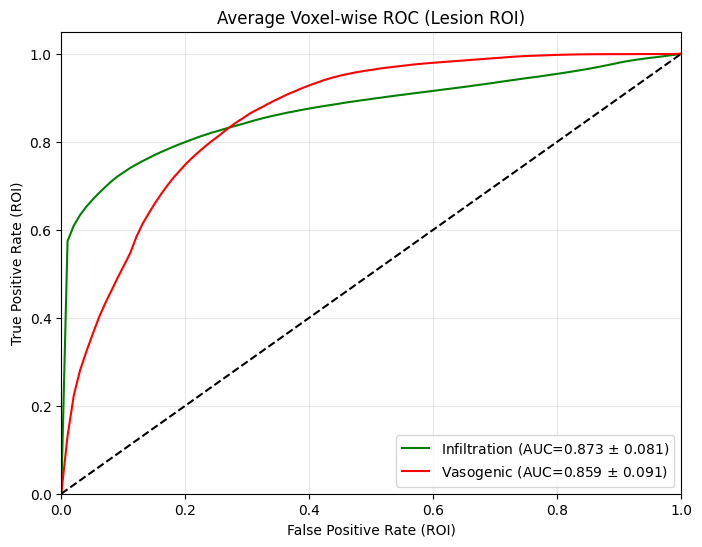

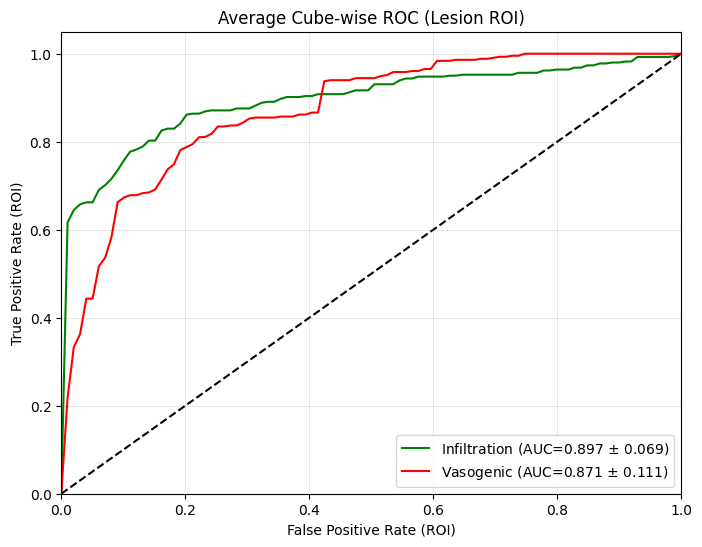

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score
from scipy import stats
import os
import numpy as np
import nibabel as nib
import torch

# ==========================================
# 1. FUNCIONES AUXILIARES
# ==========================================

def calculate_segmentation_metrics(pred, true, num_classes=3):
    """
    Calcula métricas de segmentación (Dice, Sensibilidad, Precisión, F1)
    sobre el VOLUMEN COMPLETO (incluyendo fondo).
    """
    dice_scores = []
    sensitivity_scores = []
    precision_scores = []
    f1_scores = []
    
    for cls in range(num_classes):
        pred_cls = (pred == cls).astype(np.uint8)
        true_cls = (true == cls).astype(np.uint8)
        
        tp = np.sum(pred_cls * true_cls)
        fp = np.sum(pred_cls * (1 - true_cls))
        fn = np.sum((1 - pred_cls) * true_cls)
        
        # Dice Score
        dice = 2 * tp / (2 * tp + fp + fn + 1e-6)
        dice_scores.append(dice)
        
        # Sensibilidad (Recall)
        sensitivity = tp / (tp + fn + 1e-6)
        sensitivity_scores.append(sensitivity)
        
        # Precisión
        precision = tp / (tp + fp + 1e-6)
        precision_scores.append(precision)
        
        # F1 Score
        f1 = f1_score(true_cls.flatten(), pred_cls.flatten(), zero_division=0)
        f1_scores.append(f1)
        
    return dice_scores, sensitivity_scores, precision_scores, f1_scores

def calculate_discriminative_roi_metrics(y_true, y_pred, y_probs_map, num_classes=3):
    """
    Calcula Accuracy y AUC/ROC restringido a la ROI de LESIÓN.
    La ROI se define como la unión de las clases 1 y 2 del Ground Truth.
    """
    # 1. Definir ROI: Unión de clases Infiltración (1) y Vasogénico (2)
    roi_mask = (y_true == 1) | (y_true == 2)
    
    auc_list = [np.nan] * num_classes
    fpr_list = [np.nan] * num_classes
    tpr_list = [np.nan] * num_classes
    accuracy_val = np.nan
    
    # Si hay lesión en el GT
    if np.sum(roi_mask) > 0:
        # Extraer datos dentro de la ROI
        roi_true = y_true[roi_mask]
        roi_pred = y_pred[roi_mask]
        
        # Calcular Accuracy discriminativa (Qué tan bien distingue 1 de 2)
        accuracy_val = accuracy_score(roi_true, roi_pred)
        
        # Calcular AUC por clase (Solo para 1 y 2)
        # Se indexa el mapa de probabilidades: [Clases, N_elementos_en_ROI]
        roi_probs = y_probs_map[:, roi_mask] 
        
        for cls in [1, 2]:
            # Binarizar: Clase actual vs La otra clase de lesión
            # (Ej: Infiltración=1 vs Vasogénico=0, ignorando fondo)
            bin_true = (roi_true == cls).astype(np.uint8)
            bin_score = roi_probs[cls]
            
            # Solo calculamos si hay al menos una instancia de cada clase o variación
            if len(np.unique(bin_true)) > 1:
                auc_list[cls] = roc_auc_score(bin_true, bin_score)
                fpr, tpr, _ = roc_curve(bin_true, bin_score)
                fpr_list[cls] = fpr
                tpr_list[cls] = tpr
                
    return accuracy_val, auc_list, fpr_list, tpr_list

def get_cube_data(volume, prob_maps, cube_size, num_classes=3):
    """
    Transforma volúmenes de vóxeles a cubos (Region-wise).
    - Labels: Moda del cubo.
    - Probs: Promedio del cubo.
    """
    dims = volume.shape
    n_x, n_y, n_z = dims[0] // cube_size, dims[1] // cube_size, dims[2] // cube_size
    
    cube_labels = np.zeros((n_x, n_y, n_z), dtype=np.uint8)
    cube_probs = np.zeros((num_classes, n_x, n_y, n_z))
    
    for i in range(n_x):
        for j in range(n_y):
            for k in range(n_z):
                # Extraer sub-volumen (cubo)
                sl_x = slice(i*cube_size, (i+1)*cube_size)
                sl_y = slice(j*cube_size, (j+1)*cube_size)
                sl_z = slice(k*cube_size, (k+1)*cube_size)
                
                vol_cube = volume[sl_x, sl_y, sl_z]
                prob_cube = prob_maps[:, sl_x, sl_y, sl_z]
                
                # Etiqueta: Moda
                mode_res = stats.mode(vol_cube.flatten(), keepdims=True)
                cube_labels[i, j, k] = mode_res.mode[0]
                
                # Probabilidad: Media
                for cls in range(num_classes):
                    cube_probs[cls, i, j, k] = np.mean(prob_cube[cls])
                    
    return cube_labels, cube_probs

def get_center_distance(pred_mask, true_mask, target_class=1):
    """Calcula distancia euclidiana entre centros de masa de la clase objetivo."""
    p_mask = (pred_mask == target_class)
    t_mask = (true_mask == target_class)
    
    if np.sum(p_mask) == 0 or np.sum(t_mask) == 0:
        return np.nan
        
    p_center = np.mean(np.where(p_mask), axis=1)
    t_center = np.mean(np.where(t_mask), axis=1)
    
    return np.linalg.norm(p_center - t_center)

# ==========================================
# 2. INICIALIZACIÓN
# ==========================================

# Voxel-wise Storage
metrics_voxel = {
    'dice': {0:[], 1:[], 2:[]},
    'sens': {0:[], 1:[], 2:[]},
    'prec': {0:[], 1:[], 2:[]},
    'f1':   {0:[], 1:[], 2:[]},
    'auc':  {0:[], 1:[], 2:[]}, # ROI-based
    'fpr':  {0:[], 1:[], 2:[]}, # ROI-based
    'tpr':  {0:[], 1:[], 2:[]}, # ROI-based
    'acc':  [],                 # ROI-based
    'dist': []
}

# Cube-wise Storage
metrics_cube = {
    'dice': {0:[], 1:[], 2:[]},
    'sens': {0:[], 1:[], 2:[]},
    'prec': {0:[], 1:[], 2:[]},
    'f1':   {0:[], 1:[], 2:[]},
    'auc':  {0:[], 1:[], 2:[]}, # ROI-based
    'fpr':  {0:[], 1:[], 2:[]}, # ROI-based
    'tpr':  {0:[], 1:[], 2:[]}, # ROI-based
    'acc':  [],                 # ROI-based
    'dist': []
}

cube_size = 8  # Tamaño del cubo

# ==========================================
# 3. BUCLE DE PROCESAMIENTO
# ==========================================
print(f"Iniciando evaluación completa (Voxel & Cube size {cube_size})...")

for idx, ((embeddings1, labels1), (embeddings2, labels2)) in enumerate(zip(loader_model1, loader_model2)):
    
    # --- A. Preparar Mapas ---
    prob_maps1 = generate_probability_maps(embeddings1, projection_head1, classifier1, device)
    prob_maps2 = generate_probability_maps(embeddings2, projection_head2, classifier2, device)
    
    # Combinar mapas: (Pipe1 y Pipe2)
    # - Clase 0: del modelo 1
    # - Clase 1: máximo entre ambos modelos
    # - Clase 2: del modelo 2
    combined_prob_maps = torch.zeros_like(prob_maps1)  # [3, 128, 128, 128]
    combined_prob_maps[0] = prob_maps1[0]  # Clase 0 del modelo 1
    combined_prob_maps[1] = torch.max(prob_maps1[1], prob_maps2[1])  # Clase 1 máximo entre ambos
    combined_prob_maps[2] = prob_maps2[2]  # Clase 2 del modelo 2
    # Normalizar probabilidades para que sumen 1 en cada vóxel
    combined_prob_maps = combined_prob_maps / combined_prob_maps.sum(dim=0, keepdim=True)

    # # Solo Pipe1
    # combined_prob_maps = prob_maps1

    # # Solo Pipe2
    # combined_prob_maps = prob_maps2
    
    # Numpy Conversions
    prob_maps_np = combined_prob_maps.cpu().numpy() # [3, D, H, W]
    prob_nifti = np.transpose(prob_maps_np, (1, 2, 3, 0)) # [D, H, W, 3] para guardar
    
    segmentation_np = np.argmax(prob_maps_np, axis=0).astype(np.uint8)
    labels_np = labels2.squeeze(0).cpu().numpy().astype(np.uint8)
    
    # ------------------------------------------------
    # NIVEL 1: VOXEL-WISE
    # ------------------------------------------------
    
    # 1.1 Métricas de Segmentación (Globales)
    d, s, p, f = calculate_segmentation_metrics(segmentation_np, labels_np)
    
    # 1.2 Métricas Discriminativas (ROI de Lesión)
    acc_roi, auc_roi, fpr_roi, tpr_roi = calculate_discriminative_roi_metrics(
        labels_np, segmentation_np, prob_maps_np
    )
    
    # 1.3 Distancia Espacial
    dist_v = get_center_distance(segmentation_np, labels_np, target_class=1)
    
    # 1.4 Guardar Voxel Metrics
    metrics_voxel['acc'].append(acc_roi)
    metrics_voxel['dist'].append(dist_v)
    for c in range(3):
        metrics_voxel['dice'][c].append(d[c])
        metrics_voxel['sens'][c].append(s[c])
        metrics_voxel['prec'][c].append(p[c])
        metrics_voxel['f1'][c].append(f[c])
        metrics_voxel['auc'][c].append(auc_roi[c])
        metrics_voxel['fpr'][c].append(fpr_roi[c])
        metrics_voxel['tpr'][c].append(tpr_roi[c])

    # 1.5 Plot ROC Voxel (Individual Case)
    plt.figure(figsize=(6, 5))
    for c in [1, 2]:
        if not np.isnan(auc_roi[c]):
            plt.plot(fpr_roi[c], tpr_roi[c], label=f'Class {c} (AUC={auc_roi[c]:.2f})')
    plt.plot([0,1],[0,1], 'k--')
    plt.title(f'Voxel ROC (Lesion ROI) - Case {idx}')
    plt.legend()
    plt.savefig(os.path.join(output_dir, f"roc_voxel_case_{idx}.png"))
    plt.close()

    # ------------------------------------------------
    # NIVEL 2: CUBE-WISE (REGION-BASED)
    # ------------------------------------------------
    
    # 2.1 Transformar a Cubos
    cube_labels, cube_probs = get_cube_data(labels_np, prob_maps_np, cube_size)
    cube_preds = np.argmax(cube_probs, axis=0).astype(np.uint8)
    
    # 2.2 Métricas de Segmentación Cubos (Globales)
    dc, sc, pc, fc = calculate_segmentation_metrics(cube_preds, cube_labels)
    
    # 2.3 Métricas Discriminativas Cubos (ROI de Lesión)
    acc_roi_c, auc_roi_c, fpr_roi_c, tpr_roi_c = calculate_discriminative_roi_metrics(
        cube_labels, cube_preds, cube_probs
    )
    
    # 2.4 Distancia Espacial Cubos
    dist_c = get_center_distance(cube_preds, cube_labels, target_class=1)
    # Escalar distancia de cubos a mm reales (aprox) si se desea, o dejar en unidades de cubo
    # Aquí lo dejamos en unidades de cubo para comparar con la lógica de región
    
    # 2.5 Guardar Cube Metrics
    metrics_cube['acc'].append(acc_roi_c)
    metrics_cube['dist'].append(dist_c)
    for c in range(3):
        metrics_cube['dice'][c].append(dc[c])
        metrics_cube['sens'][c].append(sc[c])
        metrics_cube['prec'][c].append(pc[c])
        metrics_cube['f1'][c].append(fc[c])
        metrics_cube['auc'][c].append(auc_roi_c[c])
        metrics_cube['fpr'][c].append(fpr_roi_c[c])
        metrics_cube['tpr'][c].append(tpr_roi_c[c])
        
    # 2.6 Plot ROC Cube (Individual Case)
    plt.figure(figsize=(6, 5))
    for c in [1, 2]:
        if not np.isnan(auc_roi_c[c]):
            plt.plot(fpr_roi_c[c], tpr_roi_c[c], linestyle='--', label=f'Class {c} (AUC={auc_roi_c[c]:.2f})')
    plt.plot([0,1],[0,1], 'k--')
    plt.title(f'Cube ROC (Lesion ROI) - Case {idx}')
    plt.legend()
    plt.savefig(os.path.join(output_dir, f"roc_cube_case_{idx}.png"))
    plt.close()
    
    # --- Guardar Archivos NIfTI (Opcional) ---
    nib.save(nib.Nifti1Image(prob_nifti, affine), os.path.join(output_dir, f"prob_case_{idx}.nii.gz"))
    nib.save(nib.Nifti1Image(segmentation_np, affine), os.path.join(output_dir, f"seg_voxel_case_{idx}.nii.gz"))
    
    # Guardar Cubos (Ajustar affine para visualización correcta)
    affine_cube = affine.copy()
    affine_cube[:3, :3] *= cube_size
    nib.save(nib.Nifti1Image(cube_preds, affine_cube), os.path.join(output_dir, f"seg_cube_case_{idx}.nii.gz"))
    
    print(f"Caso {idx} Procesado. Dice Inf Voxel: {d[1]:.3f} | Dice Inf Cube: {dc[1]:.3f}")

# ==========================================
# 4. REPORTES Y GRÁFICOS FINALES
# ==========================================

def print_summary(metrics_dict, label):
    print(f"\n{'='*20} {label} REPORT {'='*20}")
    cls_names = ['Background', 'Infiltration', 'Vasogenic']
    
    for c in range(3):
        print(f"\n--- Clase: {cls_names[c]} ---")
        d_m = np.nanmean(metrics_dict['dice'][c])
        s_m = np.nanmean(metrics_dict['sens'][c])
        p_m = np.nanmean(metrics_dict['prec'][c])
        
        print(f"Dice: {d_m:.4f} ± {np.nanstd(metrics_dict['dice'][c]):.4f}")
        print(f"Sens: {s_m:.4f} ± {np.nanstd(metrics_dict['sens'][c]):.4f}")
        print(f"Prec: {p_m:.4f} ± {np.nanstd(metrics_dict['prec'][c]):.4f}")
        
        if c > 0: # Solo imprimir AUC para lesiones
            auc_m = np.nanmean(metrics_dict['auc'][c])
            print(f"ROI AUC: {auc_m:.4f} ± {np.nanstd(metrics_dict['auc'][c]):.4f}")
            
    print(f"\nGlobal ROI Accuracy: {np.nanmean(metrics_dict['acc']):.4f}")
    print(f"Center Distance: {np.nanmean(metrics_dict['dist']):.4f}")

def plot_average_roc(metrics_dict, filename, title):
    plt.figure(figsize=(8, 6))
    colors = ['gray', 'green', 'red']
    classes = ['Background', 'Infiltration', 'Vasogenic']
    mean_fpr = np.linspace(0, 1, 100)
    
    # Solo graficamos clases 1 y 2
    for c in [1, 2]:
        tprs = []
        aucs = []
        for i in range(len(metrics_dict['fpr'][c])):
            fpr_i = metrics_dict['fpr'][c][i]
            tpr_i = metrics_dict['tpr'][c][i]
            
            # Verificar si hay datos válidos
            if isinstance(fpr_i, np.ndarray) and len(fpr_i) > 1:
                tpr_interp = np.interp(mean_fpr, fpr_i, tpr_i)
                tpr_interp[0] = 0.0
                tprs.append(tpr_interp)
                aucs.append(metrics_dict['auc'][c][i])
        
        if len(tprs) > 0:
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.nanmean(aucs)
            std_auc = np.nanstd(aucs)
            plt.plot(mean_fpr, mean_tpr, color=colors[c], 
                     label=f'{classes[c]} (AUC={mean_auc:.3f} $\pm$ {std_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate (ROI)')
    plt.ylabel('True Positive Rate (ROI)')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(output_dir, filename))
    plt.show()

# Imprimir Resúmenes
print_summary(metrics_voxel, "VOXEL-WISE")
print_summary(metrics_cube, f"CUBE-WISE (Size {cube_size})")

# Graficar Curvas Promedio
plot_average_roc(metrics_voxel, "average_roc_voxel.png", "Average Voxel-wise ROC (Lesion ROI)")
plot_average_roc(metrics_cube, "average_roc_cube.png", f"Average Cube-wise ROC (Lesion ROI)")

## Solo Pipe 1

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score
from scipy import stats
import os
import numpy as np
import nibabel as nib
import torch

# Función para calcular métricas (ya definida previamente)
def calculate_metrics(pred, true, prob_maps=None, num_classes=3):
    dice_scores = []
    sensitivity_scores = []
    precision_scores = []
    auc_scores = []
    f1_scores = []
    
    accuracy = accuracy_score(true.flatten(), pred.flatten())
    
    for cls in range(num_classes):
        pred_cls = (pred == cls).astype(np.uint8)
        true_cls = (true == cls).astype(np.uint8)
        
        tp = np.sum(pred_cls * true_cls)
        fp = np.sum(pred_cls * (1 - true_cls))
        fn = np.sum((1 - pred_cls) * true_cls)
        
        dice = 2 * tp / (2 * tp + fp + fn + 1e-6)
        dice_scores.append(dice)
        
        sensitivity = tp / (tp + fn + 1e-6)
        sensitivity_scores.append(sensitivity)
        
        precision = tp / (tp + fp + 1e-6)
        precision_scores.append(precision)
        
        f1 = f1_score(true_cls.flatten(), pred_cls.flatten(), zero_division=0)
        f1_scores.append(f1)
        
        if prob_maps is not None:
            try:
                auc = roc_auc_score(true_cls.flatten(), prob_maps[cls].flatten())
                auc_scores.append(auc)
            except ValueError:
                auc_scores.append(np.nan)
        else:
            auc_scores.append(np.nan)
    
    return dice_scores, sensitivity_scores, precision_scores, auc_scores, accuracy, f1_scores

# Función para dividir en cubos y obtener clases predominantes
def get_cube_labels(volume, cube_size, num_classes=3):
    dims = volume.shape
    assert dims[0] % cube_size == 0, "El tamaño del cubo debe dividir exactamente el tamaño del volumen"
    num_cubes = dims[0] // cube_size
    
    cube_labels = np.zeros((num_cubes, num_cubes, num_cubes), dtype=np.uint8)
    cube_probs = np.zeros((num_classes, num_cubes, num_cubes, num_cubes))
    
    for i in range(num_cubes):
        for j in range(num_cubes):
            for k in range(num_cubes):
                cube = volume[i*cube_size:(i+1)*cube_size, 
                             j*cube_size:(j+1)*cube_size, 
                             k*cube_size:(k+1)*cube_size]
                # Clase predominante (modo)
                mode_value = stats.mode(cube.flatten(), keepdims=True)[0][0]
                cube_labels[i, j, k] = mode_value
                # Proporción de cada clase como "probabilidad" suavizada
                for cls in range(num_classes):
                    cube_probs[cls, i, j, k] = np.mean(cube == cls)
    
    return cube_labels, cube_probs

# Listas para métricas voxel-wise
all_dice = {0: [], 1: [], 2: []}
all_sensitivity = {0: [], 1: [], 2: []}
all_precision = {0: [], 1: [], 2: []}
all_auc = {0: [], 1: [], 2: []}
all_accuracy = []
all_f1 = {0: [], 1: [], 2: []}
# Listas para almacenar FPR y TPR de todos los casos
all_fpr = {0: [], 1: [], 2: []}
all_tpr = {0: [], 1: [], 2: []}
all_center_distance_voxel = []

# Listas para métricas cube-wise
all_dice_cube = {0: [], 1: [], 2: []}
all_sensitivity_cube = {0: [], 1: [], 2: []}
all_precision_cube = {0: [], 1: [], 2: []}
all_auc_cube = {0: [], 1: [], 2: []}
all_accuracy_cube = []
all_f1_cube = {0: [], 1: [], 2: []}
all_center_distance=[]
# Listas para almacenar FPR y TPR de todos los casos
all_fpr_cube = {0: [], 1: [], 2: []}
all_tpr_cube = {0: [], 1: [], 2: []}

# Tamaño del cubo (ajusta según necesites)
cube_size = 8  # 128 / 8 = 16 cubos por dimensión

# Procesar y combinar
for idx, ((embeddings1, labels1), (embeddings2, labels2)) in enumerate(zip(loader_model1, loader_model2)):
    # Generar mapas de probabilidad para ambos modelos
    prob_maps1 = generate_probability_maps(embeddings1, projection_head1, classifier1, device)  # [3, 128, 128, 128]
    prob_maps2 = generate_probability_maps(embeddings2, projection_head2, classifier2, device)  # [3, 128, 128, 128]
    
    # Combinar mapas
    # combined_prob_maps = torch.zeros_like(prob_maps1)
    # combined_prob_maps[0] = prob_maps1[0]
    # combined_prob_maps[1] = torch.max(prob_maps1[1], prob_maps2[1])
    # combined_prob_maps[2] = prob_maps2[2]

    combined_prob_maps = prob_maps2 #prob_maps1

    # Convertir a numpy
    prob_maps_np = combined_prob_maps.cpu().numpy()  # [3, 128, 128, 128]
    prob_maps_np_nifti = np.transpose(prob_maps_np, (1, 2, 3, 0))  # [128, 128, 128, 3]
    
    # Generar segmentación semántica
    segmentation = np.argmax(prob_maps_np, axis=0)
    # Colocar nuevo umbral para infiltracion
    # class_1_mask = prob_maps_np[1] > 0.4
    # segmentation[class_1_mask] = 1
    segmentation_np = segmentation.astype(np.uint8)
    
    # Etiquetas
    labels = labels1.squeeze(0)
    labels_np = labels.cpu().numpy().astype(np.uint8)
    
    # Calcular métricas voxel-wise
    dice, sensitivity, precision, auc, accuracy, f1 = calculate_metrics(segmentation_np, labels_np, prob_maps=prob_maps_np)
    
    # Almacenar métricas voxel-wise
    for cls in range(3):
        all_dice[cls].append(dice[cls])
        all_sensitivity[cls].append(sensitivity[cls])
        all_precision[cls].append(precision[cls])
        all_auc[cls].append(auc[cls])
        all_f1[cls].append(f1[cls])
    all_accuracy.append(accuracy)

    # ***** NUEVO: Análisis espacial voxel-wise para la clase Infiltrado (Clase 1) *****
    infiltrado_pred_voxel = (segmentation_np == 1).astype(np.uint8)
    infiltrado_true_voxel = (labels_np == 1).astype(np.uint8)
    if np.sum(infiltrado_pred_voxel) > 0:
        pred_center_voxel = np.mean(np.where(infiltrado_pred_voxel), axis=1)
    else:
        pred_center_voxel = np.array([np.nan, np.nan, np.nan])
    if np.sum(infiltrado_true_voxel) > 0:
        true_center_voxel = np.mean(np.where(infiltrado_true_voxel), axis=1)
    else:
        true_center_voxel = np.array([np.nan, np.nan, np.nan])
    distance_voxel = np.linalg.norm(pred_center_voxel - true_center_voxel) if not np.any(np.isnan(pred_center_voxel)) and not np.any(np.isnan(true_center_voxel)) else np.nan
    all_center_distance_voxel.append(distance_voxel)

    # Graficar curvas ROC
    plt.figure(figsize=(8, 6))
    class_names = ["Fondo", "Vasogénico", "Infiltrado"]
    colors = ['blue', 'green', 'red']
    
    for cls in range(3):
        # Etiquetas binarias para la clase actual
        true_cls = (labels_np == cls).astype(np.uint8).flatten()
        prob_cls = prob_maps_np[cls].flatten()
        
        # Calcular puntos de la curva ROC
        fpr, tpr, _ = roc_curve(true_cls, prob_cls)
        auc_value = auc[cls]  # Usar el AUC calculado previamente
        all_fpr[cls].append(fpr)
        all_tpr[cls].append(tpr)
        
        # Graficar
        plt.plot(fpr, tpr, color=colors[cls], label=f'{class_names[cls]} (AUC = {auc_value:.4f})')
    
    # Configurar el gráfico
    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal (clasificador aleatorio)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title(f'Curva ROC - Caso {idx}')
    plt.legend(loc="lower right")
    
    # Guardar el gráfico
    roc_output_path = os.path.join(output_dir, f"roc_curve_case_{idx}.png")
    plt.savefig(roc_output_path)
    plt.close()
    print(f"Guardada curva ROC en {roc_output_path}")
    
    ################################
    # Evaluación basada en cubos
    ####################################
    pred_cube_labels, pred_cube_probs = get_cube_labels(segmentation_np, cube_size)
    true_cube_labels, true_cube_probs = get_cube_labels(labels_np, cube_size)
    
    # Calcular métricas cube-wise
    dice_cube, sensitivity_cube, precision_cube, auc_cube, accuracy_cube, f1_cube = calculate_metrics(
        pred_cube_labels, true_cube_labels, prob_maps=pred_cube_probs
    )
    
    # Almacenar métricas cube-wise
    for cls in range(3):
        all_dice_cube[cls].append(dice_cube[cls])
        all_sensitivity_cube[cls].append(sensitivity_cube[cls])
        all_precision_cube[cls].append(precision_cube[cls])
        all_auc_cube[cls].append(auc_cube[cls])
        all_f1_cube[cls].append(f1_cube[cls])
    all_accuracy_cube.append(accuracy_cube)

    # ***** NUEVO: Calcular y graficar curvas ROC para métricas cube-wise *****
    plt.figure(figsize=(8, 6))
    class_names = ["Fondo", "Vasogénico", "Infiltrado"]
    colors = ['blue', 'green', 'red']
    
    for cls in range(3):
        # Etiquetas binarias para la clase actual (cube-wise)
        true_cls_cube = (true_cube_labels == cls).astype(np.uint8).flatten()
        prob_cls_cube = pred_cube_probs[cls].flatten()
        
        # Calcular puntos de la curva ROC
        fpr_cube, tpr_cube, _ = roc_curve(true_cls_cube, prob_cls_cube)
        auc_value_cube = auc_cube[cls]  # Usar el AUC calculado previamente
        all_fpr_cube[cls].append(fpr_cube)
        all_tpr_cube[cls].append(tpr_cube)
        
        # Graficar
        plt.plot(fpr_cube, tpr_cube, color=colors[cls], label=f'{class_names[cls]} (AUC = {auc_value_cube:.4f})')
    
    # Configurar el gráfico
    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal (clasificador aleatorio)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title(f'Curva ROC Cube-wise - Caso {idx}')
    plt.legend(loc="lower right")
    
    # Guardar el gráfico
    roc_cube_output_path = os.path.join(output_dir, f"roc_curve_cube_case_{idx}.png")
    plt.savefig(roc_cube_output_path)
    plt.close()
    print(f"Guardada curva ROC cube-wise en {roc_cube_output_path}")
    
    # Mapa de coincidencias/discrepancias
    match_map = (pred_cube_labels == true_cube_labels).astype(np.uint8)
    mismatch_map = (pred_cube_labels != true_cube_labels).astype(np.uint8)
    
    # Guardar mapas de cubos y coincidencias
    affine = np.eye(4) * cube_size  # Ajustar el affine para reflejar el tamaño del cubo
    nib.save(nib.Nifti1Image(pred_cube_labels, affine), os.path.join(output_dir, f"pred_cube_labels_case_{idx}.nii.gz"))
    nib.save(nib.Nifti1Image(true_cube_labels, affine), os.path.join(output_dir, f"true_cube_labels_case_{idx}.nii.gz"))
    nib.save(nib.Nifti1Image(match_map, affine), os.path.join(output_dir, f"match_map_case_{idx}.nii.gz"))
    nib.save(nib.Nifti1Image(mismatch_map, affine), os.path.join(output_dir, f"mismatch_map_case_{idx}.nii.gz"))
    
    # Análisis espacial (centro de masa de la clase Infiltrado)
    infiltrado_pred = (pred_cube_labels == 1).astype(np.uint8)
    infiltrado_true = (true_cube_labels == 1).astype(np.uint8)
    if np.sum(infiltrado_pred) > 0:
        pred_center = np.mean(np.where(infiltrado_pred), axis=1)
    else:
        pred_center = np.array([np.nan, np.nan, np.nan])
    if np.sum(infiltrado_true) > 0:
        true_center = np.mean(np.where(infiltrado_true), axis=1)
    else:
        true_center = np.array([np.nan, np.nan, np.nan])
    distance = np.linalg.norm(pred_center - true_center) if not np.any(np.isnan(pred_center)) and not np.any(np.isnan(true_center)) else np.nan
    all_center_distance.append(distance)

    print(f"Caso {idx} - Voxel-wise:")
    print(f"  Dice: {dice}, Sensitivity: {sensitivity}, Precision: {precision}, AUC-ROC: {auc}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1}")
    print(f"  Centro de masa Infiltrado (Pred, Voxel-wise): {pred_center_voxel}")
    print(f"  Centro de masa Infiltrado (True, Voxel-wise): {true_center_voxel}")
    print(f"  Distancia entre centros (Voxel-wise): {distance_voxel}")

    print(f"Caso {idx} - Cube-wise (tamaño {cube_size}):")
    print(f"  Dice: {dice_cube}, Sensitivity: {sensitivity_cube}, Precision: {precision_cube}, "
          f"AUC-ROC: {auc_cube}, Accuracy: {accuracy_cube:.4f}, F1 Score: {f1_cube}")
    print(f"  Centro de masa Infiltrado (Pred): {pred_center}")
    print(f"  Centro de masa Infiltrado (True): {true_center}")
    print(f"Distancia entre centros: {distance}")
    
    # Guardar mapas de probabilidad y segmentaciones voxel-wise
    nib.save(nib.Nifti1Image(prob_maps_np_nifti, np.eye(4)), os.path.join(output_dir, f"probability_maps_case_{idx}.nii.gz"))
    nib.save(nib.Nifti1Image(labels_np, np.eye(4)), os.path.join(output_dir, f"labels_case_{idx}.nii.gz"))
    nib.save(nib.Nifti1Image(segmentation_np, np.eye(4)), os.path.join(output_dir, f"segmentation_case_{idx}.nii.gz"))

# Calcular promedios y desviaciones estándar (voxel-wise)
class_names = ["Fondo", "Infiltrado", "Vasogénico", ]
print("\nResultados Voxel-wise:")
for cls in range(3):
    dice_mean = np.nanmean(all_dice[cls])
    dice_std = np.nanstd(all_dice[cls])
    sens_mean = np.nanmean(all_sensitivity[cls])
    sens_std = np.nanstd(all_sensitivity[cls])
    prec_mean = np.nanmean(all_precision[cls])
    prec_std = np.nanstd(all_precision[cls])
    auc_mean = np.nanmean(all_auc[cls])
    auc_std = np.nanstd(all_auc[cls])
    f1_mean = np.nanmean(all_f1[cls])
    f1_std = np.nanstd(all_f1[cls])
    
    print(f"\nClase {cls} ({class_names[cls]}):")
    print(f"  Dice: {dice_mean:.4f} ± {dice_std:.4f}")
    print(f"  Sensibilidad: {sens_mean:.4f} ± {sens_std:.4f}")
    print(f"  Precisión: {prec_mean:.4f} ± {prec_std:.4f}")
    print(f"  AUC-ROC: {auc_mean:.4f} ± {auc_std:.4f}")
    print(f"  F1 Score: {f1_mean:.4f} ± {f1_std:.4f}")

accuracy_mean = np.nanmean(all_accuracy)
accuracy_std = np.nanstd(all_accuracy)
print(f"\nAccuracy Global: {accuracy_mean:.4f} ± {accuracy_std:.4f}")
# ***** NUEVO: Calcular promedio y desviación estándar para distancia voxel-wise *****
dist_mean_voxel = np.nanmean(all_center_distance_voxel)
dist_std_voxel = np.nanstd(all_center_distance_voxel)
print(f"\nDistancia entre centros Global (Voxel-wise): {dist_mean_voxel:.4f} ± {dist_std_voxel:.4f}")

# Curva ROC Promedio
plt.figure(figsize=(8, 6))
for cls in range(3):
    # Interpolar FPR y TPR a una base común
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    for fpr, tpr in zip(all_fpr[cls], all_tpr[cls]):
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0  # Asegurar que comienza en 0
        tprs.append(tpr_interp)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0  # Asegurar que termina en 1
    mean_auc = np.nanmean(all_auc[cls])
    
    plt.plot(mean_fpr, mean_tpr, color=colors[cls], label=f'{class_names[cls]} (AUC = {mean_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Promedio')
plt.legend(loc="lower right")
roc_avg_path = os.path.join(output_dir, "roc_curve_average.png")
plt.savefig(roc_avg_path)
plt.close()
print(f"Guardada curva ROC promedio en {roc_avg_path}")

# Calcular promedios y desviaciones estándar (cube-wise)
print("\nResultados Cube-wise:")
for cls in range(3):
    dice_mean = np.nanmean(all_dice_cube[cls])
    dice_std = np.nanstd(all_dice_cube[cls])
    sens_mean = np.nanmean(all_sensitivity_cube[cls])
    sens_std = np.nanstd(all_sensitivity_cube[cls])
    prec_mean = np.nanmean(all_precision_cube[cls])
    prec_std = np.nanstd(all_precision_cube[cls])
    auc_mean = np.nanmean(all_auc_cube[cls])
    auc_std = np.nanstd(all_auc_cube[cls])
    f1_mean = np.nanmean(all_f1_cube[cls])
    f1_std = np.nanstd(all_f1_cube[cls])
    
    print(f"\nClase {cls} ({class_names[cls]}):")
    print(f"  Dice: {dice_mean:.4f} ± {dice_std:.4f}")
    print(f"  Sensibilidad: {sens_mean:.4f} ± {sens_std:.4f}")
    print(f"  Precisión: {prec_mean:.4f} ± {prec_std:.4f}")
    print(f"  AUC-ROC: {auc_mean:.4f} ± {auc_std:.4f}")
    print(f"  F1 Score: {f1_mean:.4f} ± {f1_std:.4f}")

# ***** NUEVO: Curva ROC promedio para métricas cube-wise *****
print("\nGenerando curva ROC promedio para métricas cube-wise...")
plt.figure(figsize=(8, 6))
for cls in range(3):
    # Interpolar FPR y TPR a una base común
    mean_fpr_cube = np.linspace(0, 1, 100)
    tprs_cube = []
    for fpr, tpr in zip(all_fpr_cube[cls], all_tpr_cube[cls]):
        tpr_interp = np.interp(mean_fpr_cube, fpr, tpr)
        tpr_interp[0] = 0.0  # Asegurar que comienza en 0
        tprs_cube.append(tpr_interp)
    mean_tpr_cube = np.mean(tprs_cube, axis=0)
    mean_tpr_cube[-1] = 1.0  # Asegurar que termina en 1
    mean_auc_cube = np.nanmean(all_auc_cube[cls])
    
    plt.plot(mean_fpr_cube, mean_tpr_cube, color=colors[cls], label=f'{class_names[cls]} (AUC = {mean_auc_cube:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Promedio Cube-wise')
plt.legend(loc="lower right")
roc_avg_cube_path = os.path.join(output_dir, "roc_curve_average_cube.png")
plt.savefig(roc_avg_cube_path)
plt.close()
print(f"Guardada curva ROC promedio cube-wise en {roc_avg_cube_path}")

accuracy_mean_cube = np.nanmean(all_accuracy_cube)
accuracy_std_cube = np.nanstd(all_accuracy_cube)
print(f"\nAccuracy Global Cube-wise: {accuracy_mean_cube:.4f} ± {accuracy_std_cube:.4f}")

dist_mean = np.nanmean(all_center_distance)
dist_std = np.nanstd(all_center_distance)
print(f"\nDistancia entre centros Global: {dist_mean:.4f} ± {dist_std:.4f}")

Guardada curva ROC en trained_models/mapas_combinados_pipe1/roc_curve_case_0.png
Guardada curva ROC cube-wise en trained_models/mapas_combinados_pipe1/roc_curve_cube_case_0.png
Caso 0 - Voxel-wise:
  Dice: [0.9950628731270902, 0.8567807350715344, 0.6943817406462506], Sensitivity: [0.9901896122507773, 0.9955817377520293, 0.9448805460347747], Precision: [0.9999843391738426, 0.7519466072857288, 0.5488699444748991], AUC-ROC: [0.9996016598736299, 0.9996073054817175, 0.9977012889563411], Accuracy: 0.9897, F1 Score: [0.9950628731273324, 0.8567807351077312, 0.6943817406571356]
  Centro de masa Infiltrado (Pred, Voxel-wise): [61.69351131 64.77879125 59.4962551 ]
  Centro de masa Infiltrado (True, Voxel-wise): [60.96269023 65.06273932 59.91644575]
  Distancia entre centros (Voxel-wise): 0.8895426595733933
Caso 0 - Cube-wise (tamaño 8):
  Dice: [0.9980148882136457, 0.888888869135803, 0.8275861973840667], Sensitivity: [0.9960376421505603, 0.9999999500000024, 0.9473683961218844], Precision: [0.9999

# Metricas basadas en regiones centrada en tumor

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score
from scipy import stats
import os
import numpy as np
import nibabel as nib
import torch
from mpl_toolkits.mplot3d import Axes3D

# Función para calcular métricas (para todas las clases o un subconjunto)
def calculate_metrics(pred, true, prob_maps=None, num_classes=3, class_offset=0):
    dice_scores = []
    sensitivity_scores = []
    precision_scores = []
    auc_scores = []
    f1_scores = []
    
    accuracy = accuracy_score(true.flatten(), pred.flatten())
    
    for cls in range(class_offset, class_offset + num_classes):
        pred_cls = (pred == cls).astype(np.uint8)
        true_cls = (true == cls).astype(np.uint8)
        
        tp = np.sum(pred_cls * true_cls)
        fp = np.sum(pred_cls * (1 - true_cls))
        fn = np.sum((1 - pred_cls) * true_cls)
        
        dice = 2 * tp / (2 * tp + fp + fn + 1e-6)
        dice_scores.append(dice)
        
        sensitivity = tp / (tp + fn + 1e-6)
        sensitivity_scores.append(sensitivity)
        
        precision = tp / (tp + fp + 1e-6)
        precision_scores.append(precision)
        
        f1 = f1_score(true_cls.flatten(), pred_cls.flatten(), zero_division=0)
        f1_scores.append(f1)
        
        if prob_maps is not None:
            try:
                auc = roc_auc_score(true_cls.flatten(), prob_maps[cls - class_offset].flatten())
                auc_scores.append(auc)
            except ValueError:
                auc_scores.append(np.nan)
        else:
            auc_scores.append(np.nan)
    
    return dice_scores, sensitivity_scores, precision_scores, auc_scores, accuracy, f1_scores

# Función para obtener el cuadro delimitador y centro del tumor
def get_tumor_bbox_and_center(labels_np):
    tumor_mask = (labels_np > 0).astype(np.uint8)  # Clases 1 (Infiltrado) y 2 (Vasogénico)
    if np.sum(tumor_mask) == 0:
        return None, None
    indices = np.where(tumor_mask)
    bbox = {
        'x_min': np.min(indices[0]), 'x_max': np.max(indices[0]),
        'y_min': np.min(indices[1]), 'y_max': np.max(indices[1]),
        'z_min': np.min(indices[2]), 'z_max': np.max(indices[2])
    }
    center = np.mean(indices, axis=1)
    return bbox, center

# Función para dividir la región del tumor en cubos
def get_tumor_cube_labels(segmentation_np, labels_np, bbox, center, grid_size=5):
    # Dimensiones del cuadro delimitador
    dims = [bbox['x_max'] - bbox['x_min'] + 1, 
            bbox['y_max'] - bbox['y_min'] + 1, 
            bbox['z_max'] - bbox['z_min'] + 1]
    
    # Tamaño del cubo (dinámico)
    cube_size = [max(1, d // grid_size) for d in dims]
    
    # Ajustar el cuadro delimitador para centrarlo y cubrir la grilla
    half_grid = np.array([grid_size * cs / 2 for cs in cube_size])
    bbox_min = np.floor(center - half_grid).astype(int)
    bbox_max = np.ceil(center + half_grid).astype(int)
    
    # Asegurar que no exceda los límites del volumen
    bbox_min = np.maximum(bbox_min, 0)
    bbox_max = np.minimum(bbox_max, np.array(segmentation_np.shape))
    
    # Extraer la región del tumor
    tumor_pred = segmentation_np[bbox_min[0]:bbox_max[0], bbox_min[1]:bbox_max[1], bbox_min[2]:bbox_max[2]]
    tumor_true = labels_np[bbox_min[0]:bbox_max[0], bbox_min[1]:bbox_max[1], bbox_min[2]:bbox_max[2]]
    
    # Ajustar para que coincida con la grilla
    cube_labels_pred = np.zeros((grid_size, grid_size, grid_size), dtype=np.uint8)
    cube_labels_true = np.zeros((grid_size, grid_size, grid_size), dtype=np.uint8)
    cube_probs_pred = np.zeros((3, grid_size, grid_size, grid_size))  # Clases 0, 1, 2
    
    for i in range(grid_size):
        for j in range(grid_size):
            for k in range(grid_size):
                x_start = i * cube_size[0]
                y_start = j * cube_size[1]
                z_start = k * cube_size[2]
                x_end = min(x_start + cube_size[0], tumor_pred.shape[0])
                y_end = min(y_start + cube_size[1], tumor_pred.shape[1])
                z_end = min(z_start + cube_size[2], tumor_pred.shape[2])
                
                if x_end <= x_start or y_end <= y_start or z_end <= z_start:
                    continue
                
                cube_pred = tumor_pred[x_start:x_end, y_start:y_end, z_start:z_end]
                cube_true = tumor_true[x_start:x_end, y_start:y_end, z_start:z_end]
                
                # Clase predominante (incluye clase 0)
                cube_labels_pred[i, j, k] = stats.mode(cube_pred.flatten(), keepdims=True)[0][0]
                cube_labels_true[i, j, k] = stats.mode(cube_true.flatten(), keepdims=True)[0][0]
                
                # Proporciones para clases 0, 1, 2
                cube_probs_pred[0, i, j, k] = np.mean(cube_pred == 0)
                cube_probs_pred[1, i, j, k] = np.mean(cube_pred == 1)
                cube_probs_pred[2, i, j, k] = np.mean(cube_pred == 2)
    
    return cube_labels_pred, cube_labels_true, cube_probs_pred, bbox_min, bbox_max

# Listas para métricas voxel-wise (todas las clases)
all_dice = {0: [], 1: [], 2: []}
all_sensitivity = {0: [], 1: [], 2: []}
all_precision = {0: [], 1: [], 2: []}
all_auc = {0: [], 1: [], 2: []}
all_accuracy = []
all_f1 = {0: [], 1: [], 2: []}

# Listas para métricas cube-wise (todas las clases)
all_dice_cube = {0: [], 1: [], 2: []}
all_sensitivity_cube = {0: [], 1: [], 2: []}
all_precision_cube = {0: [], 1: [], 2: []}
all_auc_cube = {0: [], 1: [], 2: []}
all_accuracy_cube = []
all_f1_cube = {0: [], 1: [], 2: []}

# Configuración de la grilla (5x5x5 o 3x3x3)
grid_size = 5  # Cambia a 3 para una grilla 3x3x3

# Procesar y combinar
for idx, ((embeddings1, labels1), (embeddings2, labels2)) in enumerate(zip(loader_model1, loader_model2)):
    # Generar mapas de probabilidad
    prob_maps1 = generate_probability_maps(embeddings1, projection_head1, classifier1, device)
    prob_maps2 = generate_probability_maps(embeddings2, projection_head2, classifier2, device)
    
    # Combinar mapas
    combined_prob_maps = torch.zeros_like(prob_maps1)
    combined_prob_maps[0] = prob_maps1[0]  # Fondo
    combined_prob_maps[1] = torch.max(prob_maps1[1], prob_maps2[1])  # Infiltrado
    combined_prob_maps[2] = prob_maps2[2]  # Vasogénico
    
    # Convertir a numpy
    prob_maps_np = combined_prob_maps.cpu().numpy()
    prob_maps_np_nifti = np.transpose(prob_maps_np, (1, 2, 3, 0))
    
    # Generar segmentación
    segmentation = np.argmax(prob_maps_np, axis=0)
    # class_1_mask = prob_maps_np[1] > 0.4  # Umbral para Infiltrado
    # segmentation[class_1_mask] = 1
    segmentation_np = segmentation.astype(np.uint8)
    
    # Etiquetas
    labels = labels2.squeeze(0)
    labels_np = labels.cpu().numpy().astype(np.uint8)
    
    # Calcular métricas voxel-wise
    dice, sensitivity, precision, auc, accuracy, f1 = calculate_metrics(
        segmentation_np, labels_np, prob_maps=prob_maps_np, num_classes=3, class_offset=0
    )
    
    # Almacenar métricas voxel-wise
    for cls in range(3):
        all_dice[cls].append(dice[cls])
        all_sensitivity[cls].append(sensitivity[cls])
        all_precision[cls].append(precision[cls])
        all_auc[cls].append(auc[cls])
        all_f1[cls].append(f1[cls])
    all_accuracy.append(accuracy)
    
    # Obtener cuadro delimitador y centro del tumor
    bbox, center = get_tumor_bbox_and_center(labels_np)
    if bbox is None:
        print(f"Caso {idx}: No se detectó tumor en el ground truth. Saltando evaluación cube-wise.")
        continue
    
    # Evaluación basada en cubos
    cube_labels_pred, cube_labels_true, cube_probs_pred, bbox_min, bbox_max = get_tumor_cube_labels(
        segmentation_np, labels_np, bbox, center, grid_size=grid_size
    )
    
    # Calcular métricas cube-wise (clases 0, 1, 2)
    dice_cube, sensitivity_cube, precision_cube, auc_cube, accuracy_cube, f1_cube = calculate_metrics(
        cube_labels_pred, cube_labels_true, prob_maps=cube_probs_pred, num_classes=3, class_offset=0
    )
    
    # Almacenar métricas cube-wise
    for cls in range(3):
        all_dice_cube[cls].append(dice_cube[cls])
        all_sensitivity_cube[cls].append(sensitivity_cube[cls])
        all_precision_cube[cls].append(precision_cube[cls])
        all_auc_cube[cls].append(auc_cube[cls])
        all_f1_cube[cls].append(f1_cube[cls])
    all_accuracy_cube.append(accuracy_cube)
    
    # Mapa de coincidencias/discrepancias
    match_map = (cube_labels_pred == cube_labels_true).astype(np.uint8)
    mismatch_map = (cube_labels_pred != cube_labels_true).astype(np.uint8)
    
    # Guardar mapas de cubos
    affine = np.eye(4)
    affine[:3, 3] = bbox_min  # Ajustar origen al cuadro delimitador
    nib.save(nib.Nifti1Image(cube_labels_pred, affine), 
             os.path.join(output_dir, f"pred_cube_labels_case_{idx}.nii.gz"))
    nib.save(nib.Nifti1Image(cube_labels_true, affine), 
             os.path.join(output_dir, f"true_cube_labels_case_{idx}.nii.gz"))
    nib.save(nib.Nifti1Image(match_map, affine), 
             os.path.join(output_dir, f"match_map_case_{idx}.nii.gz"))
    nib.save(nib.Nifti1Image(mismatch_map, affine), 
             os.path.join(output_dir, f"mismatch_map_case_{idx}.nii.gz"))
    
    # Análisis espacial (centro de masa de Infiltrado)
    infiltrado_pred = (cube_labels_pred == 1).astype(np.uint8)  # Clase 1: Infiltrado
    infiltrado_true = (cube_labels_true == 1).astype(np.uint8)
    pred_center = np.mean(np.where(infiltrado_pred), axis=1) if np.sum(infiltrado_pred) > 0 else np.array([np.nan] * 3)
    true_center = np.mean(np.where(infiltrado_true), axis=1) if np.sum(infiltrado_true) > 0 else np.array([np.nan] * 3)
    distance = np.linalg.norm(pred_center - true_center) if not np.any(np.isnan(pred_center)) and not np.any(np.isnan(true_center)) else np.nan
    
    # Visualización 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    infiltrado_pred_pos = np.where(infiltrado_pred)
    infiltrado_true_pos = np.where(infiltrado_true)
    ax.scatter(infiltrado_pred_pos[0], infiltrado_pred_pos[1], infiltrado_pred_pos[2], 
               c='red', label='Infiltrado Predicho', alpha=0.5)
    ax.scatter(infiltrado_true_pos[0], infiltrado_true_pos[1], infiltrado_true_pos[2], 
               c='blue', label='Infiltrado Verdadero', alpha=0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Infiltrado - Caso {idx} (Grilla {grid_size}x{grid_size}x{grid_size})')
    ax.legend()
    plt.savefig(os.path.join(output_dir, f"infiltrado_scatter_case_{idx}.png"))
    plt.close()
    
    # Imprimir resultados
    print(f"Caso {idx} - Voxel-wise:")
    print(f"  Dice: {dice}, Sensitivity: {sensitivity}, Precision: {precision}, AUC-ROC: {auc}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1}")
    print(f"Caso {idx} - Cube-wise (Grilla {grid_size}x{grid_size}x{grid_size}):")
    print(f"  Dice: {dice_cube}, Sensitivity: {sensitivity_cube}, Precision: {precision_cube}, "
          f"AUC-ROC: {auc_cube}, Accuracy: {accuracy_cube:.4f}, F1 Score: {f1_cube}")
    print(f"  Centro de masa Infiltrado (Pred): {pred_center}")
    print(f"  Centro de masa Infiltrado (True): {true_center}")
    print(f"  Distancia entre centros: {distance:.2f}")
    
    # Guardar mapas voxel-wise
    nib.save(nib.Nifti1Image(prob_maps_np_nifti, np.eye(4)), 
             os.path.join(output_dir, f"probability_maps_case_{idx}.nii.gz"))
    nib.save(nib.Nifti1Image(labels_np, np.eye(4)), 
             os.path.join(output_dir, f"labels_case_{idx}.nii.gz"))
    nib.save(nib.Nifti1Image(segmentation_np, np.eye(4)), 
             os.path.join(output_dir, f"segmentation_case_{idx}.nii.gz"))

# Calcular promedios y desviaciones estándar (voxel-wise)
class_names = ["Fondo", "Infiltrado", "Vasogénico"]
print("\nResultados Voxel-wise:")
for cls in range(3):
    dice_mean = np.nanmean(all_dice[cls])
    dice_std = np.nanstd(all_dice[cls])
    sens_mean = np.nanmean(all_sensitivity[cls])
    sens_std = np.nanstd(all_sensitivity[cls])
    prec_mean = np.nanmean(all_precision[cls])
    prec_std = np.nanstd(all_precision[cls])
    auc_mean = np.nanmean(all_auc[cls])
    auc_std = np.nanstd(all_auc[cls])
    f1_mean = np.nanmean(all_f1[cls])
    f1_std = np.nanstd(all_f1[cls])
    
    print(f"\nClase {cls} ({class_names[cls]}):")
    print(f"  Dice: {dice_mean:.4f} ± {dice_std:.4f}")
    print(f"  Sensibilidad: {sens_mean:.4f} ± {sens_std:.4f}")
    print(f"  Precisión: {prec_mean:.4f} ± {prec_std:.4f}")
    print(f"  AUC-ROC: {auc_mean:.4f} ± {auc_std:.4f}")
    print(f"  F1 Score: {f1_mean:.4f} ± {f1_std:.4f}")

accuracy_mean = np.nanmean(all_accuracy)
accuracy_std = np.nanstd(all_accuracy)
print(f"\nAccuracy Global: {accuracy_mean:.4f} ± {accuracy_std:.4f}")

# Calcular promedios y desviaciones estándar (cube-wise, clases 0, 1, 2)
print(f"\nResultados Cube-wise (Grilla {grid_size}x{grid_size}x{grid_size}):")
for cls in range(3):
    dice_mean = np.nanmean(all_dice_cube[cls])
    dice_std = np.nanstd(all_dice_cube[cls])
    sens_mean = np.nanmean(all_sensitivity_cube[cls])
    sens_std = np.nanstd(all_sensitivity_cube[cls])
    prec_mean = np.nanmean(all_precision_cube[cls])
    prec_std = np.nanstd(all_precision_cube[cls])
    auc_mean = np.nanmean(all_auc_cube[cls])
    auc_std = np.nanstd(all_auc_cube[cls])
    f1_mean = np.nanmean(all_f1_cube[cls])
    f1_std = np.nanstd(all_f1_cube[cls])
    
    print(f"\nClase {cls} ({class_names[cls]}):")
    print(f"  Dice: {dice_mean:.4f} ± {dice_std:.4f}")
    print(f"  Sensibilidad: {sens_mean:.4f} ± {sens_std:.4f}")
    print(f"  Precisión: {prec_mean:.4f} ± {prec_std:.4f}")
    print(f"  AUC-ROC: {auc_mean:.4f} ± {auc_std:.4f}")
    print(f"  F1 Score: {f1_mean:.4f} ± {f1_std:.4f}")

accuracy_mean_cube = np.nanmean(all_accuracy_cube)
accuracy_std_cube = np.nanstd(all_accuracy_cube)
print(f"\nAccuracy Global Cube-wise: {accuracy_mean_cube:.4f} ± {accuracy_std_cube:.4f}")

Caso 0 - Voxel-wise:
  Dice: [0.9970035703989371, 0.520193908666654, 0.6986080252122276], Sensitivity: [0.9941729438903477, 0.4651015729859273, 0.8572294069472858], Precision: [0.9998503617499696, 0.5900915958885441, 0.5895229395928157], AUC-ROC: [0.9997442857524647, 0.9908721550503753, 0.9926824584823732], Accuracy: 0.9818, F1 Score: [0.9970035703991849, 0.5201939086743189, 0.698608025218861]
Caso 0 - Cube-wise (Grilla 5x5x5):
  Dice: [0.9290322520707597, 0.5499999862500004, 0.6545454426446283], Sensitivity: [0.8780487697798931, 0.49999997727272827, 0.8571428163265326], Precision: [0.9863013563520362, 0.6111110771604957, 0.5294117491349486], AUC-ROC: [0.994895065229722, 0.823477493380406, 0.8811813186813187], Accuracy: 0.8080, F1 Score: [0.9290322580645162, 0.55, 0.6545454545454545]
  Centro de masa Infiltrado (Pred): [1.72222222 2.77777778 1.83333333]
  Centro de masa Infiltrado (True): [2.40909091 2.         1.54545455]
  Distancia entre centros: 1.08
Caso 1 - Voxel-wise:
  Dice: [0

# Guardando resultados e imagenes MRI

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from monai import transforms
import nibabel as nib
from src.custom_transforms import (ConvertToMultiChannelBasedOnAnotatedInfiltration, 
                                   ConvertToMultiChannelBasedOnBratsClassesdI)

# Dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Modelo de proyección (MLP más profundo)
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=48, hidden_dim1=256, hidden_dim2=128, output_dim=128, dropout_p=0.3):
        super(ProjectionHead, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim2, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)


# Clasificador supervisado (MLP)
class Classifier(nn.Module):
    def __init__(self, input_dim=128, hidden_dim1=256, hidden_dim2=128, num_classes=3, dropout_p=0.3):
        super(Classifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim2, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

# Función para generar mapas de probabilidad
def generate_probability_maps(embeddings, projection_head, classifier, device, batch_size=8192):
    projection_head.eval()
    classifier.eval()
    with torch.no_grad():
        embeddings = embeddings.squeeze(0).permute(1, 2, 3, 0)  # [128, 128, 128, 48]
        embeddings_flat = embeddings.reshape(-1, 48)  # [2097152, 48]
        probs_flat = []
        
        for i in range(0, embeddings_flat.shape[0], batch_size):
            batch = embeddings_flat[i:i+batch_size].to(device)
            z = projection_head(batch)  # [batch_size, 128]
            z = F.normalize(z, dim=1)
            logits = classifier(z)  # [batch_size, 3]
            probs = F.softmax(logits, dim=1)  # [batch_size, 3]
            probs_flat.append(probs.cpu())
        
        probs_flat = torch.cat(probs_flat, dim=0)  # [2097152, 3]
        probs = probs_flat.reshape(128, 128, 128, 3)  # [128, 128, 128, 3]
        probs = probs.permute(3, 0, 1, 2)  # [3, 128, 128, 128]
    
    return probs  # Tensor [3, 128, 128, 128]

# Transformaciones de MONAI
roi = (128, 128, 128)
source_k = "label"
train_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        # transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        # ConvertToMultiChannelBasedOnAnotatedInfiltration(keys="label"),
        ConvertToMultiChannelBasedOnBratsClassesdI(keys="label"),
        transforms.CropForegroundd(
            keys=["image", "label"],
            source_key=source_k,
            k_divisible=[roi[0], roi[1], roi[2]],
        ),
        transforms.RandSpatialCropd(
            keys=["image", "label"],
            roi_size=[roi[0], roi[1], roi[2]],
            random_size=False,
        ),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

# Dataset y DataLoader para imágenes MRI
dataset_path = './Dataset/Dataset_30_6'
train_set = CustomDataset(dataset_path, section="test_6", transform=train_transform)
train_loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=1)

# DataLoader para embeddings (asumiendo que son los mismos que train_loader)
loader_model1 = train_loader  # Reemplaza con tu loader real si es diferente
loader_model2 = train_loader  # Reemplaza con tu loader real si es diferente

# Directorios
output_dir = "Dataset/MRIs/combined_results_test6_10mri_test"
nifti_output_dir = os.path.join(output_dir, "nifti_volumes")
probs_output_dir = os.path.join(output_dir, "probability_maps")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(nifti_output_dir, exist_ok=True)
os.makedirs(probs_output_dir, exist_ok=True)


# Cargar modelos contrastivos preentrenados
projection_head1 = ProjectionHead(input_dim=48).to(device)
# projection_head1.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_new_pipe1_v01_m1.pth", map_location=device))
projection_head1.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_gffqpzjv.pth", map_location=device))
# projection_head1.eval()

projection_head2 = ProjectionHead(input_dim=48).to(device)
# projection_head2.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_new_pipe2_m1_1dhzmigz.pth", map_location=device))
projection_head2.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_8exzvcui.pth", map_location=device))
# projection_head2.eval()

# Cargar clasificadores preentrenados
classifier1 = Classifier(input_dim=128, num_classes=3).to(device)
# classifier1.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_pipe1_v01_m1.pth", map_location=device))
classifier1.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_gffqpzjv.pth", map_location=device))
# classifier1.eval()

classifier2 = Classifier(input_dim=128, num_classes=3).to(device)
# classifier2.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_pipe2_m1_1dhzmigz.pth", map_location=device))
classifier2.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_8exzvcui.pth", map_location=device))
# classifier2.eval()

# Hooks para embeddings
decoder_features_model1 = None
decoder_features_model2 = None

def decoder_hook_fn_model1(module, input, output):
    global decoder_features_model1
    decoder_features_model1 = output

def decoder_hook_fn_model2(module, input, output):
    global decoder_features_model2
    decoder_features_model2 = output

hook_handle_decoder1 = model1.decoder1.conv_block.register_forward_hook(decoder_hook_fn_model1)
hook_handle_decoder2 = model2.decoder1.conv_block.register_forward_hook(decoder_hook_fn_model2)

# Procesar y guardar
# Procesar y combinar
with torch.no_grad():
    for idx, (batch_data, (embeddings1, labels1), (embeddings2, labels2)) in enumerate(zip(train_loader, loader_model1, loader_model2)):
        # Obtener imágenes y metadatos
        image, label = batch_data["image"], batch_data["label"]  # [1, 11, 128, 128, 128], [1, 2, 128, 128, 128]
        image_meta = batch_data["image"].meta
        affine = image_meta.get("affine", np.eye(4)).numpy()
        
        image = image.to(device)
        label = label.squeeze(0)  # [2, 128, 128, 128]
        
        # Debug: Verificar canales one-hot
        print(f"Caso {idx}: Vasogénico channel sum (6): {label[0].sum().item()}, Infiltrado channel sum (2): {label[1].sum().item()}")
        
        # Convertir one-hot a etiquetas únicas (0, 6, 2)
        label_class = torch.zeros(label.shape[1:], dtype=torch.long)  # [128, 128, 128]
        label_class[label[0] == 1] = 6  # Vasogénico
        label_class[label[1] == 1] = 2  # Infiltrado
        labels_np = label_class.cpu().numpy().astype(np.int16)  # [128, 128, 128]
        
        # Mapear etiquetas a 0, 1, 2 para métricas
        labels_metrics = np.zeros_like(labels_np, dtype=np.int16)
        labels_metrics[labels_np == 6] = 1  # Vasogénico -> 1
        labels_metrics[labels_np == 2] = 2  # Infiltrado -> 2
        # Fondo (0) ya está correcto
        
        # Verificar etiquetas
        unique_labels = np.unique(labels_np)
        print(f"Caso {idx}: Etiquetas únicas (0, 2, 6): {unique_labels}")
        if not np.all(np.isin(unique_labels, [0, 2, 6])):
            print(f"Advertencia: Etiquetas inválidas en caso {idx}: {unique_labels}")
        if 6 not in unique_labels:
            print(f"Advertencia: Clase vasogénico (6) no presente en caso {idx}")
        
        # Obtener embeddings
        _ = model1(image)
        _ = model2(image)
        embeddings1 = decoder_features_model1
        embeddings2 = decoder_features_model2
        
        # Generar mapas de probabilidad
        prob_maps1 = generate_probability_maps(embeddings1, projection_head1, classifier1, device)  # [3, 128, 128, 128]
        prob_maps2 = generate_probability_maps(embeddings2, projection_head2, classifier2, device)  # [3, 128, 128, 128]
        
        # Combinar mapas
        combined_prob_maps = torch.zeros_like(prob_maps1)  # [3, 128, 128, 128]
        combined_prob_maps[0] = prob_maps1[0]  # Fondo (0)
        combined_prob_maps[1] = torch.max(prob_maps1[1], prob_maps2[1])  # Vasogénico (1)
        combined_prob_maps[2] = prob_maps2[2]  # Infiltrado (2)
        
        # Normalizar probabilidades
        combined_prob_maps = combined_prob_maps / (combined_prob_maps.sum(dim=0, keepdim=True) + 1e-6)
        
        # Convertir a numpy
        prob_maps_np = combined_prob_maps.cpu().numpy()  # [3, 128, 128, 128]
        prob_maps_np_nifti = np.transpose(prob_maps_np, (1, 2, 3, 0))  # [128, 128, 128, 3]
        
        # Generar segmentación semántica (clases 0, 1, 2)
        segmentation = np.argmax(prob_maps_np, axis=0)  # [128, 128, 128]
        segmentation_np = segmentation.astype(np.int16)  # [0, 1, 2]
        
        # Mapear segmentación a valores originales (0, 6, 2)
        segmentation_np_orig = np.zeros_like(segmentation_np, dtype=np.int16)
        segmentation_np_orig[segmentation_np == 1] = 6  # Vasogénico
        segmentation_np_orig[segmentation_np == 2] = 2  # Infiltrado
        # Fondo (0) ya está correcto
                
        # Guardar imágenes MRI en NIfTI
        image_np = image.squeeze(0).cpu().numpy()  # [11, 128, 128, 128]
        for channel in range(image_np.shape[0]):
            nifti_img = nib.Nifti1Image(image_np[channel], affine)
            nib.save(nifti_img, f"{nifti_output_dir}/case_{idx}_modality_{channel}.nii.gz")
        
        # Guardar etiquetas en NIfTI (valores 0, 2, 6)
        nifti_label_img = nib.Nifti1Image(labels_np, affine)
        label_output_path = os.path.join(nifti_output_dir, f"labels_case_{idx}.nii.gz")
        nib.save(nifti_label_img, label_output_path)
        print(f"Guardadas etiquetas en {label_output_path}")
        
        # Guardar mapas de probabilidad
        nifti_prob_img = nib.Nifti1Image(prob_maps_np_nifti, affine)
        prob_output_path = os.path.join(probs_output_dir, f"probability_maps_case_{idx}.nii.gz")
        nib.save(nifti_prob_img, prob_output_path)
        print(f"Guardado mapa de probabilidad en {prob_output_path}")
        
        # Guardar segmentación (valores 0, 6, 2)
        nifti_seg_img = nib.Nifti1Image(segmentation_np_orig, affine)
        seg_output_path = os.path.join(nifti_output_dir, f"segmentation_case_{idx}.nii.gz")
        nib.save(nifti_seg_img, seg_output_path)
        print(f"Guardada segmentación en {seg_output_path}")

# Remover hooks
hook_handle_decoder1.remove()
hook_handle_decoder2.remove()

Found 6 images and 6 labels.


/home/minigo/anaconda3/envs/monai_env/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


Caso 0: Vasogénico channel sum (6): 16856, Infiltrado channel sum (2): 16769
Caso 0: Etiquetas únicas (0, 2, 6): [0 2 6]
Guardadas etiquetas en Dataset/MRIs/combined_results_test6_10mri_test/nifti_volumes/labels_case_0.nii.gz
Guardado mapa de probabilidad en Dataset/MRIs/combined_results_test6_10mri_test/probability_maps/probability_maps_case_0.nii.gz
Guardada segmentación en Dataset/MRIs/combined_results_test6_10mri_test/nifti_volumes/segmentation_case_0.nii.gz
Caso 1: Vasogénico channel sum (6): 10132, Infiltrado channel sum (2): 23548
Caso 1: Etiquetas únicas (0, 2, 6): [0 2 6]
Guardadas etiquetas en Dataset/MRIs/combined_results_test6_10mri_test/nifti_volumes/labels_case_1.nii.gz
Guardado mapa de probabilidad en Dataset/MRIs/combined_results_test6_10mri_test/probability_maps/probability_maps_case_1.nii.gz
Guardada segmentación en Dataset/MRIs/combined_results_test6_10mri_test/nifti_volumes/segmentation_case_1.nii.gz
Caso 2: Vasogénico channel sum (6): 6926, Infiltrado channel sum (

# Guardando resultados Pipeline1 + Pipeline2 con Recurrencia

In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from monai import transforms
import nibabel as nib
import matplotlib.pyplot as plt
import monai.utils
from src.get_data import CustomDatasetRec

# Dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Modelo de proyección (MLP más profundo)
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=48, hidden_dim1=256, hidden_dim2=128, output_dim=128, dropout_p=0.3):
        super(ProjectionHead, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim2, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)


# Clasificador supervisado (MLP)
class Classifier(nn.Module):
    def __init__(self, input_dim=128, hidden_dim1=256, hidden_dim2=128, num_classes=3, dropout_p=0.3):
        super(Classifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim2, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

# Función para generar mapas de probabilidad
def generate_probability_maps(embeddings, projection_head, classifier, device, batch_size=8192):
    projection_head.eval()
    classifier.eval()
    with torch.no_grad():
        embeddings = embeddings.squeeze(0).permute(1, 2, 3, 0)  # [128, 128, 128, 48]
        embeddings_flat = embeddings.reshape(-1, 48)  # [2097152, 48]
        probs_flat = []
        
        for i in range(0, embeddings_flat.shape[0], batch_size):
            batch = embeddings_flat[i:i+batch_size].to(device)
            z = projection_head(batch)  # [batch_size, 128]
            z = F.normalize(z, dim=1)
            logits = classifier(z)  # [batch_size, 3]
            probs = F.softmax(logits, dim=1)  # [batch_size, 3]
            probs_flat.append(probs.cpu())
        
        probs_flat = torch.cat(probs_flat, dim=0)  # [2097152, 3]
        probs = probs_flat.reshape(128, 128, 128, 3)  # [128, 128, 128, 3]
        probs = probs.permute(3, 0, 1, 2)  # [3, 128, 128, 128]
    
    return probs  # Tensor [3, 128, 128, 128]

# Transformaciones de MONAI
roi = (128, 128, 128)
source_k = "label"
train_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        # transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        ConvertToMultiChannelBasedOnAnotatedInfiltration(keys="label"),
        transforms.CropForegroundd(
            keys=["image", "label"],
            source_key=source_k,
            k_divisible=[roi[0], roi[1], roi[2]],
        ),
        transforms.RandSpatialCropd(
            keys=["image", "label"],
            roi_size=[roi[0], roi[1], roi[2]],
            random_size=False,
        ),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)
# Transformaciones combinadas para imágenes de entrada, etiquetas y recurrencia
combined_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label", "recurrence"]),
        transforms.EnsureChannelFirstD(keys="recurrence"),
        ConvertToMultiChannelBasedOnBratsClassesdI(keys="label"),
        # ConvertToMultiChannelBasedOnAnotatedInfiltration(keys="label"),
        transforms.CropForegroundd(
            keys=["image", "label", "recurrence"],
            source_key="label",
            k_divisible=[128, 128, 128],
        ),
        transforms.RandSpatialCropd(
            keys=["image", "label", "recurrence"],
            roi_size=[128, 128, 128],
            random_size=False,
        ),
        transforms.NormalizeIntensityd(keys=["image", "recurrence"], nonzero=True, channel_wise=True),
    ]
)

# Dataset y DataLoader
dataset_path = './Dataset/Dataset_30_6'
train_set = CustomDatasetRec(dataset_path, section="test_6", transform=combined_transform)
train_loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)

# Directorios
output_dir = "Dataset/MRIs/contrastive_voxel_wise/combined_results_recurrencia_pipe1-pipe2_test6_10mri"
nifti_output_dir = os.path.join(output_dir, "nifti_volumes")
probs_output_dir = os.path.join(output_dir, "probability_maps")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(nifti_output_dir, exist_ok=True)
os.makedirs(probs_output_dir, exist_ok=True)

# Cargar modelos contrastivos preentrenados
projection_head1 = ProjectionHead(input_dim=48).to(device)
# projection_head1.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_new_pipe1_v01_m1.pth", map_location=device))
projection_head1.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_gffqpzjv.pth", map_location=device))
# projection_head1.eval()

projection_head2 = ProjectionHead(input_dim=48).to(device)
# projection_head2.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_new_pipe2_m1_1dhzmigz.pth", map_location=device))
projection_head2.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_8exzvcui.pth", map_location=device))
# projection_head2.eval()

# Cargar clasificadores preentrenados
classifier1 = Classifier(input_dim=128, num_classes=3).to(device)
# classifier1.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_pipe1_v01_m1.pth", map_location=device))
classifier1.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_gffqpzjv.pth", map_location=device))
# classifier1.eval()

classifier2 = Classifier(input_dim=128, num_classes=3).to(device)
# classifier2.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_pipe2_m1_1dhzmigz.pth", map_location=device))
classifier2.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_8exzvcui.pth", map_location=device))
# classifier2.eval()

# Hooks para embeddings
decoder_features_model1 = None
decoder_features_model2 = None

def decoder_hook_fn_model1(module, input, output):
    global decoder_features_model1
    decoder_features_model1 = output

def decoder_hook_fn_model2(module, input, output):
    global decoder_features_model2
    decoder_features_model2 = output

hook_handle_decoder1 = model1.decoder1.conv_block.register_forward_hook(decoder_hook_fn_model1)
hook_handle_decoder2 = model2.decoder1.conv_block.register_forward_hook(decoder_hook_fn_model2)


# Procesar y combinar
with torch.no_grad():
    for idx, batch_data in enumerate(train_loader):
        monai.utils.set_determinism(seed=idx)
        
        print(f"\nCaso {idx}:")
        print(f"image shape: {batch_data['image'].shape}")
        print(f"label shape: {batch_data['label'].shape}")
        print(f"recurrence shape: {batch_data['recurrence'].shape}")
        
        # Extraer datos
        image = batch_data["image"].to(device)  # [1, 11, 128, 128, 128]
        label = batch_data["label"].to(device)  # [1, 2, 128, 128, 128]
        recurrence = batch_data["recurrence"].to(device)  # [1, 1, 128, 128, 128]
                
        # Convertir recurrencia a numpy
        recurrence_np = recurrence.squeeze().cpu().numpy().astype(np.float32)  # [128, 128, 128]
        print(f"Caso {idx}: recurrence_np shape: {recurrence_np.shape}, min: {recurrence_np.min()}, max: {recurrence_np.max()}, mean: {recurrence_np.mean()}")
        
        # Debug: Verificar canales one-hot
        print(f"Caso {idx}: Vasogénico channel sum (6): {label[0, 0].sum().item()}, Infiltrado channel sum (2): {label[0, 1].sum().item()}")
        
        # Convertir one-hot a etiquetas únicas (0, 6, 2)
        label_class = torch.zeros(label.shape[2:], dtype=torch.long, device=device)  # [128, 128, 128]
        label_class[label[0, 0] == 1] = 6  # Vasogénico
        label_class[label[0, 1] == 1] = 2  # Infiltrado
        labels_np = label_class.cpu().numpy().astype(np.int16)  # [128, 128, 128]
        
        # Mapear etiquetas a 0, 1, 2 para métricas
        labels_metrics = np.zeros_like(labels_np, dtype=np.int16)
        labels_metrics[labels_np == 6] = 1  # Vasogénico -> 1
        labels_metrics[labels_np == 2] = 2  # Infiltrado -> 2
        
        # Verificar etiquetas
        unique_labels = np.unique(labels_np)
        print(f"Caso {idx}: Etiquetas únicas (0, 2, 6): {unique_labels}")
        if not np.all(np.isin(unique_labels, [0, 2, 6])):
            print(f"Advertencia: Etiquetas inválidas en caso {idx}: {unique_labels}")
        if 6 not in unique_labels:
            print(f"Advertencia: Clase vasogénico (6) no presente en caso {idx}")
        
        # Obtener embeddings
        _ = model1(image)
        _ = model2(image)
        embeddings1 = decoder_features_model1
        embeddings2 = decoder_features_model2
        
        # Generar mapas de probabilidad
        prob_maps1 = generate_probability_maps(embeddings1, projection_head1, classifier1, device)  # [3, 128, 128, 128]
        prob_maps2 = generate_probability_maps(embeddings2, projection_head2, classifier2, device)  # [3, 128, 128, 128]
        
        # Combinar mapas
        combined_prob_maps = torch.zeros_like(prob_maps1)  # [3, 128, 128, 128]
        combined_prob_maps[0] = prob_maps1[0]  # Fondo (0)
        combined_prob_maps[1] = torch.max(prob_maps1[1], prob_maps2[1])  # Vasogénico (1)
        combined_prob_maps[2] = prob_maps2[2]  # Infiltrado (2)
        
        # Normalizar probabilidades
        combined_prob_maps = combined_prob_maps / (combined_prob_maps.sum(dim=0, keepdim=True) + 1e-6)
        
        # Convertir a numpy
        prob_maps_np = combined_prob_maps.cpu().numpy()  # [3, 128, 128, 128]
        prob_maps_np_nifti = np.transpose(prob_maps_np, (1, 2, 3, 0))  # [128, 128, 128, 3]
        
        # Generar segmentación semántica (clases 0, 1, 2)
        segmentation = np.argmax(prob_maps_np, axis=0)  # [128, 128, 128]
        segmentation_np = segmentation.astype(np.int16)  # [0, 1, 2]
        
        # Mapear segmentación a valores originales (0, 6, 2)
        segmentation_np_orig = np.zeros_like(segmentation_np, dtype=np.int16)
        segmentation_np_orig[segmentation_np == 1] = 6  # Vasogénico
        segmentation_np_orig[segmentation_np == 2] = 2  # Infiltrado
        
        # Guardar imágenes MRI en NIfTI
        image_np = image.squeeze(0).cpu().numpy()  # [11, 128, 128, 128]
        for channel in range(image_np.shape[0]):
            nifti_img = nib.Nifti1Image(image_np[channel], affine, header=nib.Nifti1Header())
            nib.save(nifti_img, os.path.join(nifti_output_dir, f"case_{idx}_modality_{channel}.nii.gz"))
        
        # Guardar imagen de recurrencia en NIfTI
        nifti_recurrence_img = nib.Nifti1Image(recurrence_np, affine, header=nib.Nifti1Header())
        recurrence_output_path = os.path.join(nifti_output_dir, f"case_{idx}_recurrence.nii.gz")
        nib.save(nifti_recurrence_img, recurrence_output_path)
        print(f"Guardada imagen de recurrencia en {recurrence_output_path}")
        saved_nifti = nib.load(recurrence_output_path)
        saved_data = saved_nifti.get_fdata()
        print(f"Saved recurrence NIfTI shape: {saved_data.shape}, min: {saved_data.min()}, max: {saved_data.max()}, mean: {saved_data.mean()}")
        file_size = os.path.getsize(recurrence_output_path) / 1024  # Size in kB
        print(f"Recurrence file size: {file_size:.2f} kB")
        
        # Guardar etiquetas en NIfTI (valores 0, 2, 6)
        nifti_label_img = nib.Nifti1Image(labels_np, affine, header=nib.Nifti1Header())
        label_output_path = os.path.join(nifti_output_dir, f"labels_case_{idx}.nii.gz")
        nib.save(nifti_label_img, label_output_path)
        print(f"Guardadas etiquetas en {label_output_path}")
        
        # Guardar mapas de probabilidad
        nifti_prob_img = nib.Nifti1Image(prob_maps_np_nifti, affine, header=nib.Nifti1Header())
        prob_output_path = os.path.join(probs_output_dir, f"probability_maps_case_{idx}.nii.gz")
        nib.save(nifti_prob_img, prob_output_path)
        print(f"Guardado mapa de probabilidad en {prob_output_path}")
        
        # Guardar segmentación (valores 0, 6, 2)
        nifti_seg_img = nib.Nifti1Image(segmentation_np_orig, affine, header=nib.Nifti1Header())
        seg_output_path = os.path.join(nifti_output_dir, f"segmentation_case_{idx}.nii.gz")
        nib.save(nifti_seg_img, seg_output_path)
        print(f"Guardada segmentación en {seg_output_path}")
        
        # Restaurar aleatoriedad después de cada caso
        monai.utils.set_determinism(seed=None)

# Remover hooks
hook_handle_decoder1.remove()
hook_handle_decoder2.remove()



Found 6 images, 6 labels, and 6 recurrence files.
2025-11-18 11:42:33,282 - INFO - Apply pending transforms - lazy: None, pending: 0, upcoming 'Compose', transform.lazy: False


/home/minigo/anaconda3/envs/monai_env/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


After transforms - image shape: torch.Size([10, 128, 128, 128]), label shape: torch.Size([2, 128, 128, 128]), recurrence shape: torch.Size([1, 128, 128, 128])

Caso 0:
image shape: torch.Size([1, 10, 128, 128, 128])
label shape: torch.Size([1, 2, 128, 128, 128])
recurrence shape: torch.Size([1, 1, 128, 128, 128])
Caso 0: recurrence_np shape: (128, 128, 128), min: -2.4518356323242188, max: 10.343467712402344, mean: 1.5454133972525597e-08
Caso 0: Vasogénico channel sum (6): 40406, Infiltrado channel sum (2): 22403
Caso 0: Etiquetas únicas (0, 2, 6): [0 2 6]
Guardada imagen de recurrencia en Dataset/MRIs/contrastive_voxel_wise/combined_results_recurrencia_pipe1-pipe2_test6_10mri/nifti_volumes/case_0_recurrence.nii.gz
Saved recurrence NIfTI shape: (128, 128, 128), min: -2.4518356323242188, max: 10.343467712402344, mean: 1.4600035069811668e-08
Recurrence file size: 3104.09 kB
Guardadas etiquetas en Dataset/MRIs/contrastive_voxel_wise/combined_results_recurrencia_pipe1-pipe2_test6_10mri/nift

# Guardando resultados Pipeline 2

In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from monai import transforms
import nibabel as nib
import matplotlib.pyplot as plt
import monai.utils
from src.get_data import CustomDatasetRec

# Dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Modelo de proyección (MLP más profundo)
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=48, hidden_dim1=256, hidden_dim2=128, output_dim=128, dropout_p=0.3):
        super(ProjectionHead, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim2, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)


# Clasificador supervisado (MLP)
class Classifier(nn.Module):
    def __init__(self, input_dim=128, hidden_dim1=256, hidden_dim2=128, num_classes=3, dropout_p=0.3):
        super(Classifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim2, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

# Función para generar mapas de probabilidad
def generate_probability_maps(embeddings, projection_head, classifier, device, batch_size=8192):
    projection_head.eval()
    classifier.eval()
    with torch.no_grad():
        embeddings = embeddings.squeeze(0).permute(1, 2, 3, 0)  # [128, 128, 128, 48]
        embeddings_flat = embeddings.reshape(-1, 48)  # [2097152, 48]
        probs_flat = []
        
        for i in range(0, embeddings_flat.shape[0], batch_size):
            batch = embeddings_flat[i:i+batch_size].to(device)
            z = projection_head(batch)  # [batch_size, 128]
            z = F.normalize(z, dim=1)
            logits = classifier(z)  # [batch_size, 3]
            probs = F.softmax(logits, dim=1)  # [batch_size, 3]
            probs_flat.append(probs.cpu())
        
        probs_flat = torch.cat(probs_flat, dim=0)  # [2097152, 3]
        probs = probs_flat.reshape(128, 128, 128, 3)  # [128, 128, 128, 3]
        probs = probs.permute(3, 0, 1, 2)  # [3, 128, 128, 128]
    
    return probs  # Tensor [3, 128, 128, 128]

# Transformaciones de MONAI
roi = (128, 128, 128)
source_k = "label"
train_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        # transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        ConvertToMultiChannelBasedOnAnotatedInfiltration(keys="label"),
        transforms.CropForegroundd(
            keys=["image", "label"],
            source_key=source_k,
            k_divisible=[roi[0], roi[1], roi[2]],
        ),
        transforms.RandSpatialCropd(
            keys=["image", "label"],
            roi_size=[roi[0], roi[1], roi[2]],
            random_size=False,
        ),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)
# Transformaciones combinadas para imágenes de entrada, etiquetas y recurrencia
combined_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label", "recurrence"]),
        transforms.EnsureChannelFirstD(keys="recurrence"),
        ConvertToMultiChannelBasedOnAnotatedInfiltration(keys="label"),
        transforms.CropForegroundd(
            keys=["image", "label", "recurrence"],
            source_key="label",
            k_divisible=[128, 128, 128],
        ),
        transforms.RandSpatialCropd(
            keys=["image", "label", "recurrence"],
            roi_size=[128, 128, 128],
            random_size=False,
        ),
        transforms.NormalizeIntensityd(keys=["image", "recurrence"], nonzero=True, channel_wise=True),
    ]
)

# Dataset y DataLoader
dataset_path = './Dataset/Dataset_30_6'
train_set = CustomDatasetRec(dataset_path, section="test_6", transform=combined_transform)
train_loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)

# Directorios
output_dir = "Dataset/MRIs/contrastive_voxel_wise/combined_results-pipe2_test_6_10mri"
nifti_output_dir = os.path.join(output_dir, "nifti_volumes")
probs_output_dir = os.path.join(output_dir, "probability_maps")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(nifti_output_dir, exist_ok=True)
os.makedirs(probs_output_dir, exist_ok=True)

# Cargar modelos contrastivos preentrenados
# projection_head1 = ProjectionHead(input_dim=48).to(device)
# # projection_head1.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_new_pipe1_v01_m1.pth", map_location=device))
# projection_head1.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_gffqpzjv.pth", map_location=device))
# # projection_head1.eval()

projection_head2 = ProjectionHead(input_dim=48).to(device)
# projection_head2.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_new_pipe2_m1_1dhzmigz.pth", map_location=device))
projection_head2.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_8exzvcui.pth", map_location=device))
# projection_head2.eval()

# Cargar clasificadores preentrenados
# classifier1 = Classifier(input_dim=128, num_classes=3).to(device)
# # classifier1.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_pipe1_v01_m1.pth", map_location=device))
# classifier1.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_gffqpzjv.pth", map_location=device))
# # classifier1.eval()

classifier2 = Classifier(input_dim=128, num_classes=3).to(device)
# classifier2.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_pipe2_m1_1dhzmigz.pth", map_location=device))
classifier2.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_8exzvcui.pth", map_location=device))
# classifier2.eval()

# Hooks para embeddings
# decoder_features_model1 = None
decoder_features_model2 = None

# def decoder_hook_fn_model1(module, input, output):
#     global decoder_features_model1
#     decoder_features_model1 = output

def decoder_hook_fn_model2(module, input, output):
    global decoder_features_model2
    decoder_features_model2 = output

# hook_handle_decoder1 = model1.decoder1.conv_block.register_forward_hook(decoder_hook_fn_model1)
hook_handle_decoder2 = model2.decoder1.conv_block.register_forward_hook(decoder_hook_fn_model2)


# Procesar y combinar
with torch.no_grad():
    for idx, batch_data in enumerate(train_loader):
        monai.utils.set_determinism(seed=idx)
        
        print(f"\nCaso {idx}:")
        print(f"image shape: {batch_data['image'].shape}")
        print(f"label shape: {batch_data['label'].shape}")
        print(f"recurrence shape: {batch_data['recurrence'].shape}")
        
        # Extraer datos
        image = batch_data["image"].to(device)  # [1, 11, 128, 128, 128]
        label = batch_data["label"].to(device)  # [1, 2, 128, 128, 128]
        recurrence = batch_data["recurrence"].to(device)  # [1, 1, 128, 128, 128]
                
        # Convertir recurrencia a numpy
        recurrence_np = recurrence.squeeze().cpu().numpy().astype(np.float32)  # [128, 128, 128]
        print(f"Caso {idx}: recurrence_np shape: {recurrence_np.shape}, min: {recurrence_np.min()}, max: {recurrence_np.max()}, mean: {recurrence_np.mean()}")
        
        # Debug: Verificar canales one-hot
        print(f"Caso {idx}: Vasogénico channel sum (6): {label[0, 0].sum().item()}, Infiltrado channel sum (2): {label[0, 1].sum().item()}")
        
        # Convertir one-hot a etiquetas únicas (0, 6, 2)
        label_class = torch.zeros(label.shape[2:], dtype=torch.long, device=device)  # [128, 128, 128]
        label_class[label[0, 0] == 1] = 6  # Vasogénico
        label_class[label[0, 1] == 1] = 2  # Infiltrado
        labels_np = label_class.cpu().numpy().astype(np.int16)  # [128, 128, 128]
        
        # Mapear etiquetas a 0, 1, 2 para métricas
        labels_metrics = np.zeros_like(labels_np, dtype=np.int16)
        labels_metrics[labels_np == 6] = 1  # Vasogénico -> 1
        labels_metrics[labels_np == 2] = 2  # Infiltrado -> 2
        
        # Verificar etiquetas
        unique_labels = np.unique(labels_np)
        print(f"Caso {idx}: Etiquetas únicas (0, 2, 6): {unique_labels}")
        if not np.all(np.isin(unique_labels, [0, 2, 6])):
            print(f"Advertencia: Etiquetas inválidas en caso {idx}: {unique_labels}")
        if 6 not in unique_labels:
            print(f"Advertencia: Clase vasogénico (6) no presente en caso {idx}")
        
        # Obtener embeddings
        # _ = model1(image)
        _ = model2(image)
        # embeddings1 = decoder_features_model1
        embeddings2 = decoder_features_model2
        
        # Generar mapas de probabilidad
        # prob_maps1 = generate_probability_maps(embeddings1, projection_head1, classifier1, device)  # [3, 128, 128, 128]
        prob_maps2 = generate_probability_maps(embeddings2, projection_head2, classifier2, device)  # [3, 128, 128, 128]
        
        # # Combinar mapas
        # combined_prob_maps = torch.zeros_like(prob_maps1)  # [3, 128, 128, 128]
        # combined_prob_maps[0] = prob_maps1[0]  # Fondo (0)
        # combined_prob_maps[1] = torch.max(prob_maps1[1], prob_maps2[1])  # Vasogénico (1)
        # combined_prob_maps[2] = prob_maps2[2]  # Infiltrado (2)
        
        # Normalizar probabilidades
        combined_prob_maps = prob_maps2 / (prob_maps2.sum(dim=0, keepdim=True) + 1e-6)
        
        # Convertir a numpy
        prob_maps_np = combined_prob_maps.cpu().numpy()  # [3, 128, 128, 128]
        prob_maps_np_nifti = np.transpose(prob_maps_np, (1, 2, 3, 0))  # [128, 128, 128, 3]
        
        # Generar segmentación semántica (clases 0, 1, 2)
        segmentation = np.argmax(prob_maps_np, axis=0)  # [128, 128, 128]
        segmentation_np = segmentation.astype(np.int16)  # [0, 1, 2]
        
        # Mapear segmentación a valores originales (0, 6, 2)
        segmentation_np_orig = np.zeros_like(segmentation_np, dtype=np.int16)
        segmentation_np_orig[segmentation_np == 1] = 6  # Vasogénico
        segmentation_np_orig[segmentation_np == 2] = 2  # Infiltrado
        
        # Guardar imágenes MRI en NIfTI
        image_np = image.squeeze(0).cpu().numpy()  # [11, 128, 128, 128]
        for channel in range(image_np.shape[0]):
            nifti_img = nib.Nifti1Image(image_np[channel], affine, header=nib.Nifti1Header())
            nib.save(nifti_img, os.path.join(nifti_output_dir, f"case_{idx}_modality_{channel}.nii.gz"))
        
        # Guardar imagen de recurrencia en NIfTI
        nifti_recurrence_img = nib.Nifti1Image(recurrence_np, affine, header=nib.Nifti1Header())
        recurrence_output_path = os.path.join(nifti_output_dir, f"case_{idx}_recurrence.nii.gz")
        nib.save(nifti_recurrence_img, recurrence_output_path)
        print(f"Guardada imagen de recurrencia en {recurrence_output_path}")
        saved_nifti = nib.load(recurrence_output_path)
        saved_data = saved_nifti.get_fdata()
        print(f"Saved recurrence NIfTI shape: {saved_data.shape}, min: {saved_data.min()}, max: {saved_data.max()}, mean: {saved_data.mean()}")
        file_size = os.path.getsize(recurrence_output_path) / 1024  # Size in kB
        print(f"Recurrence file size: {file_size:.2f} kB")
        
        # Guardar etiquetas en NIfTI (valores 0, 2, 6)
        nifti_label_img = nib.Nifti1Image(labels_np, affine, header=nib.Nifti1Header())
        label_output_path = os.path.join(nifti_output_dir, f"labels_case_{idx}.nii.gz")
        nib.save(nifti_label_img, label_output_path)
        print(f"Guardadas etiquetas en {label_output_path}")
        
        # Guardar mapas de probabilidad
        nifti_prob_img = nib.Nifti1Image(prob_maps_np_nifti, affine, header=nib.Nifti1Header())
        prob_output_path = os.path.join(probs_output_dir, f"probability_maps_case_{idx}.nii.gz")
        nib.save(nifti_prob_img, prob_output_path)
        print(f"Guardado mapa de probabilidad en {prob_output_path}")
        
        # Guardar segmentación (valores 0, 6, 2)
        nifti_seg_img = nib.Nifti1Image(segmentation_np_orig, affine, header=nib.Nifti1Header())
        seg_output_path = os.path.join(nifti_output_dir, f"segmentation_case_{idx}.nii.gz")
        nib.save(nifti_seg_img, seg_output_path)
        print(f"Guardada segmentación en {seg_output_path}")
        
        # Restaurar aleatoriedad después de cada caso
        monai.utils.set_determinism(seed=None)

# Remover hooks
# hook_handle_decoder1.remove()
hook_handle_decoder2.remove()

Found 6 images, 6 labels, and 6 recurrence files.
2025-11-18 12:02:13,681 - INFO - Apply pending transforms - lazy: None, pending: 0, upcoming 'Compose', transform.lazy: False


/home/minigo/anaconda3/envs/monai_env/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


After transforms - image shape: torch.Size([10, 128, 128, 128]), label shape: torch.Size([2, 128, 128, 128]), recurrence shape: torch.Size([1, 128, 128, 128])

Caso 0:
image shape: torch.Size([1, 10, 128, 128, 128])
label shape: torch.Size([1, 2, 128, 128, 128])
recurrence shape: torch.Size([1, 1, 128, 128, 128])
Caso 0: recurrence_np shape: (128, 128, 128), min: -2.4518356323242188, max: 10.343467712402344, mean: 1.5454133972525597e-08
Caso 0: Vasogénico channel sum (6): 18101.0, Infiltrado channel sum (2): 22403.0
Caso 0: Etiquetas únicas (0, 2, 6): [0 2 6]
Guardada imagen de recurrencia en Dataset/MRIs/contrastive_voxel_wise/combined_results-pipe2_test_6_10mri/nifti_volumes/case_0_recurrence.nii.gz
Saved recurrence NIfTI shape: (128, 128, 128), min: -2.4518356323242188, max: 10.343467712402344, mean: 1.4600035069811668e-08
Recurrence file size: 3104.09 kB
Guardadas etiquetas en Dataset/MRIs/contrastive_voxel_wise/combined_results-pipe2_test_6_10mri/nifti_volumes/labels_case_0.nii.gz

# Guardando resultados pipe 1

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from monai import transforms
import nibabel as nib
import matplotlib.pyplot as plt
import monai.utils
from src.get_data import CustomDatasetRec

# Dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Modelo de proyección (MLP más profundo)
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=48, hidden_dim1=256, hidden_dim2=128, output_dim=128, dropout_p=0.3):
        super(ProjectionHead, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim2, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)


# Clasificador supervisado (MLP)
class Classifier(nn.Module):
    def __init__(self, input_dim=128, hidden_dim1=256, hidden_dim2=128, num_classes=3, dropout_p=0.3):
        super(Classifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim2, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

# Función para generar mapas de probabilidad
def generate_probability_maps(embeddings, projection_head, classifier, device, batch_size=8192):
    projection_head.eval()
    classifier.eval()
    with torch.no_grad():
        embeddings = embeddings.squeeze(0).permute(1, 2, 3, 0)  # [128, 128, 128, 48]
        embeddings_flat = embeddings.reshape(-1, 48)  # [2097152, 48]
        probs_flat = []
        
        for i in range(0, embeddings_flat.shape[0], batch_size):
            batch = embeddings_flat[i:i+batch_size].to(device)
            z = projection_head(batch)  # [batch_size, 128]
            z = F.normalize(z, dim=1)
            logits = classifier(z)  # [batch_size, 3]
            probs = F.softmax(logits, dim=1)  # [batch_size, 3]
            probs_flat.append(probs.cpu())
        
        probs_flat = torch.cat(probs_flat, dim=0)  # [2097152, 3]
        probs = probs_flat.reshape(128, 128, 128, 3)  # [128, 128, 128, 3]
        probs = probs.permute(3, 0, 1, 2)  # [3, 128, 128, 128]
    
    return probs  # Tensor [3, 128, 128, 128]

# Transformaciones de MONAI
roi = (128, 128, 128)
source_k = "label"
# Transformaciones combinadas para imágenes de entrada, etiquetas y recurrencia
combined_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label", "recurrence"]),
        transforms.EnsureChannelFirstD(keys="recurrence"),
        # ConvertToMultiChannelBasedOnAnotatedInfiltration(keys="label"),
        ConvertToMultiChannelBasedOnBratsClassesdI(keys="label"),
        transforms.CropForegroundd(
            keys=["image", "label", "recurrence"],
            source_key="label",
            k_divisible=[128, 128, 128],
        ),
        transforms.RandSpatialCropd(
            keys=["image", "label", "recurrence"],
            roi_size=[128, 128, 128],
            random_size=False,
        ),
        transforms.NormalizeIntensityd(keys=["image", "recurrence"], nonzero=True, channel_wise=True),
    ]
)

# Dataset y DataLoader
dataset_path = './Dataset/Dataset_30_6'
train_set = CustomDatasetRec(dataset_path, section="train_30", transform=combined_transform)
train_loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)

# Directorios
output_dir = "Dataset/MRIs/contrastive_voxel_wise/combined_results-pipe1_train_30"
nifti_output_dir = os.path.join(output_dir, "nifti_volumes")
probs_output_dir = os.path.join(output_dir, "probability_maps")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(nifti_output_dir, exist_ok=True)
os.makedirs(probs_output_dir, exist_ok=True)

# Cargar modelos contrastivos preentrenados
projection_head1 = ProjectionHead(input_dim=48).to(device)
projection_head1.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_new_pipe1_v01_m1.pth", map_location=device))
# projection_head1.eval()

# projection_head2 = ProjectionHead(input_dim=48).to(device)
# projection_head2.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_new_pipe2_m1_1dhzmigz.pth", map_location=device))
# # projection_head2.eval()

# Cargar clasificadores preentrenados
classifier1 = Classifier(input_dim=128, num_classes=3).to(device)
classifier1.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_pipe1_v01_m1.pth", map_location=device))
# classifier1.eval()

# classifier2 = Classifier(input_dim=128, num_classes=3).to(device)
# classifier2.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_pipe2_m1_1dhzmigz.pth", map_location=device))
# # classifier2.eval()

# Hooks para embeddings
decoder_features_model1 = None
# decoder_features_model2 = None

def decoder_hook_fn_model1(module, input, output):
    global decoder_features_model1
    decoder_features_model1 = output

# def decoder_hook_fn_model2(module, input, output):
#     global decoder_features_model2
#     decoder_features_model2 = output

hook_handle_decoder1 = model1.decoder1.conv_block.register_forward_hook(decoder_hook_fn_model1)
# hook_handle_decoder2 = model2.decoder1.conv_block.register_forward_hook(decoder_hook_fn_model2)


# Procesar y combinar
with torch.no_grad():
    for idx, batch_data in enumerate(train_loader):
        monai.utils.set_determinism(seed=idx)
        
        print(f"\nCaso {idx}:")
        print(f"image shape: {batch_data['image'].shape}")
        print(f"label shape: {batch_data['label'].shape}")
        print(f"recurrence shape: {batch_data['recurrence'].shape}")
        
        # Extraer datos
        image = batch_data["image"].to(device)  # [1, 11, 128, 128, 128]
        label = batch_data["label"].to(device)  # [1, 2, 128, 128, 128]
        recurrence = batch_data["recurrence"].to(device)  # [1, 1, 128, 128, 128]

        image_meta = batch_data["image"].meta
        affine = image_meta.get("affine", np.eye(4)).numpy()
                
        # Convertir recurrencia a numpy
        recurrence_np = recurrence.squeeze().cpu().numpy().astype(np.float32)  # [128, 128, 128]
        print(f"Caso {idx}: recurrence_np shape: {recurrence_np.shape}, min: {recurrence_np.min()}, max: {recurrence_np.max()}, mean: {recurrence_np.mean()}")
        
        # Debug: Verificar canales one-hot
        print(f"Caso {idx}: Vasogénico channel sum (6): {label[0, 0].sum().item()}, Infiltrado channel sum (2): {label[0, 1].sum().item()}")
        
        # Convertir one-hot a etiquetas únicas (0, 6, 2)
        label_class = torch.zeros(label.shape[2:], dtype=torch.long, device=device)  # [128, 128, 128]
        label_class[label[0, 0] == 1] = 6  # Vasogénico
        label_class[label[0, 1] == 1] = 2  # Infiltrado
        labels_np = label_class.cpu().numpy().astype(np.int16)  # [128, 128, 128]
        
        # Mapear etiquetas a 0, 1, 2 para métricas
        labels_metrics = np.zeros_like(labels_np, dtype=np.int16)
        labels_metrics[labels_np == 6] = 1  # Vasogénico -> 1
        labels_metrics[labels_np == 2] = 2  # Infiltrado -> 2
        
        # Verificar etiquetas
        unique_labels = np.unique(labels_np)
        print(f"Caso {idx}: Etiquetas únicas (0, 2, 6): {unique_labels}")
        if not np.all(np.isin(unique_labels, [0, 2, 6])):
            print(f"Advertencia: Etiquetas inválidas en caso {idx}: {unique_labels}")
        if 6 not in unique_labels:
            print(f"Advertencia: Clase vasogénico (6) no presente en caso {idx}")
        
        # Obtener embeddings
        _ = model1(image)
        # _ = model2(image)
        embeddings1 = decoder_features_model1
        # embeddings2 = decoder_features_model2
        
        # Generar mapas de probabilidad
        prob_maps1 = generate_probability_maps(embeddings1, projection_head1, classifier1, device)  # [3, 128, 128, 128]
        # prob_maps2 = generate_probability_maps(embeddings2, projection_head2, classifier2, device)  # [3, 128, 128, 128]
        
        # # Combinar mapas
        # combined_prob_maps = torch.zeros_like(prob_maps1)  # [3, 128, 128, 128]
        # combined_prob_maps[0] = prob_maps1[0]  # Fondo (0)
        # combined_prob_maps[1] = torch.max(prob_maps1[1], prob_maps2[1])  # Vasogénico (1)
        # combined_prob_maps[2] = prob_maps2[2]  # Infiltrado (2)
        
        # Normalizar probabilidades
        combined_prob_maps = prob_maps1 / (prob_maps1.sum(dim=0, keepdim=True) + 1e-6)
        
        # Convertir a numpy
        prob_maps_np = combined_prob_maps.cpu().numpy()  # [3, 128, 128, 128]
        prob_maps_np_nifti = np.transpose(prob_maps_np, (1, 2, 3, 0))  # [128, 128, 128, 3]
        
        # Generar segmentación semántica (clases 0, 1, 2)
        segmentation = np.argmax(prob_maps_np, axis=0)  # [128, 128, 128]
        segmentation_np = segmentation.astype(np.int16)  # [0, 1, 2]
        
        # Mapear segmentación a valores originales (0, 6, 2)
        segmentation_np_orig = np.zeros_like(segmentation_np, dtype=np.int16)
        segmentation_np_orig[segmentation_np == 1] = 6  # Vasogénico
        segmentation_np_orig[segmentation_np == 2] = 2  # Infiltrado
        
        # Guardar imágenes MRI en NIfTI
        image_np = image.squeeze(0).cpu().numpy()  # [11, 128, 128, 128]
        for channel in range(image_np.shape[0]):
            nifti_img = nib.Nifti1Image(image_np[channel], affine, header=nib.Nifti1Header())
            nib.save(nifti_img, os.path.join(nifti_output_dir, f"case_{idx}_modality_{channel}.nii.gz"))
        
        # Guardar imagen de recurrencia en NIfTI
        nifti_recurrence_img = nib.Nifti1Image(recurrence_np, affine, header=nib.Nifti1Header())
        recurrence_output_path = os.path.join(nifti_output_dir, f"case_{idx}_recurrence.nii.gz")
        nib.save(nifti_recurrence_img, recurrence_output_path)
        print(f"Guardada imagen de recurrencia en {recurrence_output_path}")
        saved_nifti = nib.load(recurrence_output_path)
        saved_data = saved_nifti.get_fdata()
        print(f"Saved recurrence NIfTI shape: {saved_data.shape}, min: {saved_data.min()}, max: {saved_data.max()}, mean: {saved_data.mean()}")
        file_size = os.path.getsize(recurrence_output_path) / 1024  # Size in kB
        print(f"Recurrence file size: {file_size:.2f} kB")
        
        # Guardar etiquetas en NIfTI (valores 0, 2, 6)
        nifti_label_img = nib.Nifti1Image(labels_np, affine, header=nib.Nifti1Header())
        label_output_path = os.path.join(nifti_output_dir, f"labels_case_{idx}.nii.gz")
        nib.save(nifti_label_img, label_output_path)
        print(f"Guardadas etiquetas en {label_output_path}")
        
        # Guardar mapas de probabilidad
        nifti_prob_img = nib.Nifti1Image(prob_maps_np_nifti, affine, header=nib.Nifti1Header())
        prob_output_path = os.path.join(probs_output_dir, f"probability_maps_case_{idx}.nii.gz")
        nib.save(nifti_prob_img, prob_output_path)
        print(f"Guardado mapa de probabilidad en {prob_output_path}")
        
        # Guardar segmentación (valores 0, 6, 2)
        nifti_seg_img = nib.Nifti1Image(segmentation_np_orig, affine, header=nib.Nifti1Header())
        seg_output_path = os.path.join(nifti_output_dir, f"segmentation_case_{idx}.nii.gz")
        nib.save(nifti_seg_img, seg_output_path)
        print(f"Guardada segmentación en {seg_output_path}")
        
        # Restaurar aleatoriedad después de cada caso
        monai.utils.set_determinism(seed=None)

# Remover hooks
hook_handle_decoder1.remove()
# hook_handle_decoder2.remove()

Found 6 images, 6 labels, and 6 recurrence files.
2025-06-20 13:11:46,329 - INFO - Apply pending transforms - lazy: None, pending: 0, upcoming 'Compose', transform.lazy: False


/home/training2/miniconda3/envs/monai_env/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


After transforms - image shape: torch.Size([11, 128, 128, 128]), label shape: torch.Size([2, 128, 128, 128]), recurrence shape: torch.Size([1, 128, 128, 128])

Caso 0:
image shape: torch.Size([1, 11, 128, 128, 128])
label shape: torch.Size([1, 2, 128, 128, 128])
recurrence shape: torch.Size([1, 1, 128, 128, 128])
Caso 0: recurrence_np shape: (128, 128, 128), min: -2.4518356323242188, max: 10.343467712402344, mean: 1.5454133972525597e-08
Caso 0: Vasogénico channel sum (6): 22305, Infiltrado channel sum (2): 40504
Caso 0: Etiquetas únicas (0, 2, 6): [0 2 6]
Guardada imagen de recurrencia en Dataset/MRIs/contrastive_voxel_wise/combined_results-pipe1/nifti_volumes/case_0_recurrence.nii.gz
Saved recurrence NIfTI shape: (128, 128, 128), min: -2.4518356323242188, max: 10.343467712402344, mean: 1.4600035069811668e-08
Recurrence file size: 3104.10 kB
Guardadas etiquetas en Dataset/MRIs/contrastive_voxel_wise/combined_results-pipe1/nifti_volumes/labels_case_0.nii.gz
Guardado mapa de probabilidad

## MRIs y metricas Pipe1

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from monai import transforms
import nibabel as nib
import matplotlib.pyplot as plt
import monai.utils
from src.get_data import CustomDatasetRec
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score
from scipy import stats

# Dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Modelo de proyección (MLP más profundo)
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=48, hidden_dim1=256, hidden_dim2=128, output_dim=128, dropout_p=0.3):
        super(ProjectionHead, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim2, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)


# Clasificador supervisado (MLP)
class Classifier(nn.Module):
    def __init__(self, input_dim=128, hidden_dim1=256, hidden_dim2=128, num_classes=3, dropout_p=0.3):
        super(Classifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            # nn.Dropout(dropout_p),
            nn.Linear(hidden_dim2, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

# Función para generar mapas de probabilidad
def generate_probability_maps(embeddings, projection_head, classifier, device, batch_size=8192):
    projection_head.eval()
    classifier.eval()
    with torch.no_grad():
        embeddings = embeddings.squeeze(0).permute(1, 2, 3, 0)  # [128, 128, 128, 48]
        embeddings_flat = embeddings.reshape(-1, 48)  # [2097152, 48]
        probs_flat = []
        
        for i in range(0, embeddings_flat.shape[0], batch_size):
            batch = embeddings_flat[i:i+batch_size].to(device)
            z = projection_head(batch)  # [batch_size, 128]
            z = F.normalize(z, dim=1)
            logits = classifier(z)  # [batch_size, 3]
            probs = F.softmax(logits, dim=1)  # [batch_size, 3]
            probs_flat.append(probs.cpu())
        
        probs_flat = torch.cat(probs_flat, dim=0)  # [2097152, 3]
        probs = probs_flat.reshape(128, 128, 128, 3)  # [128, 128, 128, 3]
        probs = probs.permute(3, 0, 1, 2)  # [3, 128, 128, 128]
    
    return probs  # Tensor [3, 128, 128, 128]

# =================================================================================
# INICIO: FUNCIONES AÑADIDAS PARA EL CÁLCULO DE MÉTRICAS
# =================================================================================

# Función para calcular métricas
def calculate_metrics(pred, true, prob_maps=None, num_classes=3):
    dice_scores = []
    sensitivity_scores = []
    precision_scores = []
    auc_scores = []
    f1_scores = []
    
    accuracy = accuracy_score(true.flatten(), pred.flatten())
    
    for cls in range(num_classes):
        pred_cls = (pred == cls).astype(np.uint8)
        true_cls = (true == cls).astype(np.uint8)
        
        tp = np.sum(pred_cls * true_cls)
        fp = np.sum(pred_cls * (1 - true_cls))
        fn = np.sum((1 - pred_cls) * true_cls)
        
        dice = 2 * tp / (2 * tp + fp + fn + 1e-6)
        dice_scores.append(dice)
        
        sensitivity = tp / (tp + fn + 1e-6)
        sensitivity_scores.append(sensitivity)
        
        precision = tp / (tp + fp + 1e-6)
        precision_scores.append(precision)
        
        f1 = f1_score(true_cls.flatten(), pred_cls.flatten(), zero_division=0)
        f1_scores.append(f1)
        
        if prob_maps is not None:
            try:
                auc = roc_auc_score(true_cls.flatten(), prob_maps[cls].flatten())
                auc_scores.append(auc)
            except ValueError:
                auc_scores.append(np.nan)
        else:
            auc_scores.append(np.nan)
    
    return dice_scores, sensitivity_scores, precision_scores, auc_scores, accuracy, f1_scores

# Función para dividir en cubos y obtener clases predominantes
def get_cube_labels(volume, cube_size, num_classes=3):
    dims = volume.shape
    assert all(d % cube_size == 0 for d in dims), "El tamaño del cubo debe dividir exactamente las dimensiones del volumen"
    
    num_cubes_dims = [d // cube_size for d in dims]
    
    cube_labels = np.zeros(num_cubes_dims, dtype=np.uint8)
    cube_probs = np.zeros([num_classes] + num_cubes_dims)
    
    for i in range(num_cubes_dims[0]):
        for j in range(num_cubes_dims[1]):
            for k in range(num_cubes_dims[2]):
                cube = volume[i*cube_size:(i+1)*cube_size, 
                              j*cube_size:(j+1)*cube_size, 
                              k*cube_size:(k+1)*cube_size]
                # Clase predominante (modo)
                mode_value = stats.mode(cube.flatten(), keepdims=True)[0][0]
                cube_labels[i, j, k] = mode_value
                # Proporción de cada clase como "probabilidad" suavizada
                for cls in range(num_classes):
                    cube_probs[cls, i, j, k] = np.mean(cube == cls)
    
    return cube_labels, cube_probs

# =================================================================================
# FIN: FUNCIONES AÑADIDAS PARA EL CÁLCULO DE MÉTRICAS
# =================================================================================

# Transformaciones de MONAI
roi = (128, 128, 128)
source_k = "label"
# Transformaciones combinadas para imágenes de entrada, etiquetas y recurrencia
combined_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label", "recurrence"]),
        transforms.EnsureChannelFirstD(keys="recurrence"),
        # ConvertToMultiChannelBasedOnAnotatedInfiltration(keys="label"),
        ConvertToMultiChannelBasedOnBratsClassesdI(keys="label"),
        transforms.CropForegroundd(
            keys=["image", "label", "recurrence"],
            source_key="label",
            k_divisible=[128, 128, 128],
        ),
        transforms.RandSpatialCropd(
            keys=["image", "label", "recurrence"],
            roi_size=[128, 128, 128],
            random_size=False,
        ),
        transforms.NormalizeIntensityd(keys=["image", "recurrence"], nonzero=True, channel_wise=True),
    ]
)

# Dataset y DataLoader
dataset_path = './Dataset/Dataset_30_6'
train_set = CustomDatasetRec(dataset_path, section="test_6", transform=combined_transform)
train_loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)

# Directorios
output_dir = "Dataset/MRIs/contrastive_voxel_wise/combined_results-pipe1"
nifti_output_dir = os.path.join(output_dir, "nifti_volumes")
probs_output_dir = os.path.join(output_dir, "probability_maps")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(nifti_output_dir, exist_ok=True)
os.makedirs(probs_output_dir, exist_ok=True)

# Cargar modelos contrastivos preentrenados
projection_head1 = ProjectionHead(input_dim=48).to(device)
projection_head1.load_state_dict(torch.load("trained_models/checkpoints_contrastive/contrastive_projection_head_final_new_pipe1_v01_m1.pth", map_location=device))

# Cargar clasificadores preentrenados
classifier1 = Classifier(input_dim=128, num_classes=3).to(device)
classifier1.load_state_dict(torch.load("trained_models/checkpoints/supervised_classifier_final_pipe1_v01_m1.pth", map_location=device))

# Hooks para embeddings
decoder_features_model1 = None

def decoder_hook_fn_model1(module, input, output):
    global decoder_features_model1
    decoder_features_model1 = output

# Asegúrate de que `model1` esté definido y cargado antes de esta línea.
# Por ejemplo: model1 = YourModelClass().to(device)
# model1.load_state_dict(torch.load("path/to/your/model1.pth"))
hook_handle_decoder1 = model1.decoder1.conv_block.register_forward_hook(decoder_hook_fn_model1)


# =================================================================================
# INICIO: INICIALIZACIÓN DE VARIABLES PARA MÉTRICAS
# =================================================================================
# Listas para métricas voxel-wise
all_dice = {0: [], 1: [], 2: []}
all_sensitivity = {0: [], 1: [], 2: []}
all_precision = {0: [], 1: [], 2: []}
all_auc = {0: [], 1: [], 2: []}
all_accuracy = []
all_f1 = {0: [], 1: [], 2: []}
all_fpr = {0: [], 1: [], 2: []}
all_tpr = {0: [], 1: [], 2: []}
all_center_distance_voxel = []

# Listas para métricas cube-wise
all_dice_cube = {0: [], 1: [], 2: []}
all_sensitivity_cube = {0: [], 1: [], 2: []}
all_precision_cube = {0: [], 1: [], 2: []}
all_auc_cube = {0: [], 1: [], 2: []}
all_accuracy_cube = []
all_f1_cube = {0: [], 1: [], 2: []}
all_center_distance = []
all_fpr_cube = {0: [], 1: [], 2: []}
all_tpr_cube = {0: [], 1: [], 2: []}

# Tamaño del cubo
cube_size = 8
class_names = ["Fondo", "Vasogénico", "Infiltrado"]
colors = ['blue', 'green', 'red']

# =================================================================================
# FIN: INICIALIZACIÓN DE VARIABLES PARA MÉTRICAS
# =================================================================================


# Procesar y combinar
with torch.no_grad():
    for idx, batch_data in enumerate(train_loader):
        monai.utils.set_determinism(seed=idx)
        
        print(f"\nCaso {idx}:")
        print(f"image shape: {batch_data['image'].shape}")
        
        # Extraer datos
        image = batch_data["image"].to(device)
        label = batch_data["label"].to(device)
        recurrence = batch_data["recurrence"].to(device)
        image_meta = batch_data["image"].meta
        affine = image_meta.get("affine", np.eye(4)).numpy()

        # Convertir recurrencia a numpy
        recurrence_np = recurrence.squeeze().cpu().numpy().astype(np.float32)
        
        # Convertir one-hot a etiquetas únicas (0, 6, 2)
        label_class = torch.zeros(label.shape[2:], dtype=torch.long, device=device)
        label_class[label[0, 0] == 1] = 6  # Vasogénico
        label_class[label[0, 1] == 1] = 2  # Infiltrado
        labels_np = label_class.cpu().numpy().astype(np.int16)
        
        # Mapear etiquetas a 0, 1, 2 para métricas
        labels_metrics = np.zeros_like(labels_np, dtype=np.int16)
        labels_metrics[labels_np == 6] = 1  # Vasogénico -> 1
        labels_metrics[labels_np == 2] = 2  # Infiltrado -> 2
        
        # Obtener embeddings
        _ = model1(image)
        embeddings1 = decoder_features_model1
        
        # Generar mapas de probabilidad
        prob_maps1 = generate_probability_maps(embeddings1, projection_head1, classifier1, device)
        
        # Normalizar probabilidades
        combined_prob_maps = prob_maps1 / (prob_maps1.sum(dim=0, keepdim=True) + 1e-6)
        
        # Convertir a numpy
        prob_maps_np = combined_prob_maps.cpu().numpy()
        prob_maps_np_nifti = np.transpose(prob_maps_np, (1, 2, 3, 0))
        
        # Generar segmentación semántica (clases 0, 1, 2)
        segmentation = np.argmax(prob_maps_np, axis=0)
        segmentation_np = segmentation.astype(np.int16)
        
        # Mapear segmentación a valores originales (0, 6, 2)
        segmentation_np_orig = np.zeros_like(segmentation_np, dtype=np.int16)
        segmentation_np_orig[segmentation_np == 1] = 6  # Vasogénico
        segmentation_np_orig[segmentation_np == 2] = 2  # Infiltrado

        # =================================================================================
        # INICIO: BLOQUE DE CÁLCULO Y ALMACENAMIENTO DE MÉTRICAS
        # =================================================================================

        # --- Métricas Voxel-wise ---
        dice, sensitivity, precision, auc, accuracy, f1 = calculate_metrics(segmentation_np, labels_metrics, prob_maps=prob_maps_np)
        
        for cls in range(3):
            all_dice[cls].append(dice[cls])
            all_sensitivity[cls].append(sensitivity[cls])
            all_precision[cls].append(precision[cls])
            all_auc[cls].append(auc[cls])
            all_f1[cls].append(f1[cls])
        all_accuracy.append(accuracy)

        # Análisis espacial voxel-wise para la clase Infiltrado (Clase 2)
        infiltrado_pred_voxel = (segmentation_np == 2).astype(np.uint8)
        infiltrado_true_voxel = (labels_metrics == 2).astype(np.uint8)
        pred_center_voxel = np.mean(np.where(infiltrado_pred_voxel), axis=1) if np.sum(infiltrado_pred_voxel) > 0 else np.array([np.nan, np.nan, np.nan])
        true_center_voxel = np.mean(np.where(infiltrado_true_voxel), axis=1) if np.sum(infiltrado_true_voxel) > 0 else np.array([np.nan, np.nan, np.nan])
        distance_voxel = np.linalg.norm(pred_center_voxel - true_center_voxel) if not np.any(np.isnan(pred_center_voxel)) and not np.any(np.isnan(true_center_voxel)) else np.nan
        all_center_distance_voxel.append(distance_voxel)

        # Guardar curva ROC individual (voxel-wise)
        plt.figure(figsize=(8, 6))
        for cls in range(3):
            true_cls = (labels_metrics == cls).flatten()
            prob_cls = prob_maps_np[cls].flatten()
            fpr, tpr, _ = roc_curve(true_cls, prob_cls)
            auc_value = auc[cls]
            all_fpr[cls].append(fpr)
            all_tpr[cls].append(tpr)
            plt.plot(fpr, tpr, color=colors[cls], label=f'{class_names[cls]} (AUC = {auc_value:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('Tasa de Falsos Positivos (FPR)'); plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
        plt.title(f'Curva ROC Voxel-wise - Caso {idx}'); plt.legend(loc="lower right")
        roc_output_path = os.path.join(output_dir, f"roc_curve_voxel_case_{idx}.png")
        plt.savefig(roc_output_path)
        plt.close()

        # --- Métricas Cube-wise ---
        pred_cube_labels, pred_cube_probs = get_cube_labels(segmentation_np, cube_size)
        true_cube_labels, _ = get_cube_labels(labels_metrics, cube_size)
        
        dice_cube, sens_cube, prec_cube, auc_cube, acc_cube, f1_cube = calculate_metrics(
            pred_cube_labels, true_cube_labels, prob_maps=pred_cube_probs
        )
        
        for cls in range(3):
            all_dice_cube[cls].append(dice_cube[cls])
            all_sensitivity_cube[cls].append(sens_cube[cls])
            all_precision_cube[cls].append(prec_cube[cls])
            all_auc_cube[cls].append(auc_cube[cls])
            all_f1_cube[cls].append(f1_cube[cls])
        all_accuracy_cube.append(acc_cube)

        # Guardar curva ROC individual (cube-wise)
        plt.figure(figsize=(8, 6))
        for cls in range(3):
            true_cls_cube = (true_cube_labels == cls).flatten()
            prob_cls_cube = pred_cube_probs[cls].flatten()
            fpr_cube, tpr_cube, _ = roc_curve(true_cls_cube, prob_cls_cube)
            auc_value_cube = auc_cube[cls]
            all_fpr_cube[cls].append(fpr_cube)
            all_tpr_cube[cls].append(tpr_cube)
            plt.plot(fpr_cube, tpr_cube, color=colors[cls], label=f'{class_names[cls]} (AUC = {auc_value_cube:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('Tasa de Falsos Positivos (FPR)'); plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
        plt.title(f'Curva ROC Cube-wise - Caso {idx}'); plt.legend(loc="lower right")
        roc_cube_output_path = os.path.join(output_dir, f"roc_curve_cube_case_{idx}.png")
        plt.savefig(roc_cube_output_path)
        plt.close()

        # Análisis espacial cube-wise para la clase Infiltrado (Clase 2)
        infiltrado_pred_cube = (pred_cube_labels == 2).astype(np.uint8)
        infiltrado_true_cube = (true_cube_labels == 2).astype(np.uint8)
        pred_center_cube = np.mean(np.where(infiltrado_pred_cube), axis=1) if np.sum(infiltrado_pred_cube) > 0 else np.array([np.nan, np.nan, np.nan])
        true_center_cube = np.mean(np.where(infiltrado_true_cube), axis=1) if np.sum(infiltrado_true_cube) > 0 else np.array([np.nan, np.nan, np.nan])
        distance_cube = np.linalg.norm(pred_center_cube - true_center_cube) if not np.any(np.isnan(pred_center_cube)) and not np.any(np.isnan(true_center_cube)) else np.nan
        all_center_distance.append(distance_cube)
        
        print(f"--- Resultados para Caso {idx} ---")
        print(f"Voxel-wise - Dice: {dice}, Accuracy: {accuracy:.4f}, Distancia Centros (Infiltrado): {distance_voxel:.4f}")
        print(f"Cube-wise  - Dice: {dice_cube}, Accuracy: {acc_cube:.4f}, Distancia Centros (Infiltrado): {distance_cube:.4f}")

        # =================================================================================
        # FIN: BLOQUE DE CÁLCULO Y ALMACENAMIENTO DE MÉTRICAS
        # =================================================================================
        
        # --- Guardado de Archivos NIfTI ---
        # Guardar imágenes MRI
        image_np = image.squeeze(0).cpu().numpy()
        for channel in range(image_np.shape[0]):
            nib.save(nib.Nifti1Image(image_np[channel], affine), os.path.join(nifti_output_dir, f"case_{idx}_modality_{channel}.nii.gz"))
        
        # Guardar recurrencia, etiquetas, mapas de probabilidad y segmentación
        nib.save(nib.Nifti1Image(recurrence_np, affine), os.path.join(nifti_output_dir, f"case_{idx}_recurrence.nii.gz"))
        nib.save(nib.Nifti1Image(labels_np, affine), os.path.join(nifti_output_dir, f"labels_case_{idx}.nii.gz"))
        nib.save(nib.Nifti1Image(prob_maps_np_nifti, affine), os.path.join(probs_output_dir, f"probability_maps_case_{idx}.nii.gz"))
        nib.save(nib.Nifti1Image(segmentation_np_orig, affine), os.path.join(nifti_output_dir, f"segmentation_case_{idx}.nii.gz"))
        
        print(f"Archivos NIfTI para caso {idx} guardados en {nifti_output_dir} y {probs_output_dir}")
        
        monai.utils.set_determinism(seed=None)

# Remover hook
hook_handle_decoder1.remove()


# =================================================================================
# INICIO: ANÁLISIS FINAL Y GUARDADO DE RESULTADOS AGREGADOS
# =================================================================================

print("\n--- Resultados Finales Agregados ---")

# --- Resultados Voxel-wise ---
print("\nResultados Voxel-wise:")
for cls in range(3):
    print(f"\nClase {cls} ({class_names[cls]}):")
    print(f"  Dice:       {np.nanmean(all_dice[cls]):.4f} ± {np.nanstd(all_dice[cls]):.4f}")
    print(f"  Sensibilidad: {np.nanmean(all_sensitivity[cls]):.4f} ± {np.nanstd(all_sensitivity[cls]):.4f}")
    print(f"  Precisión:    {np.nanmean(all_precision[cls]):.4f} ± {np.nanstd(all_precision[cls]):.4f}")
    print(f"  AUC-ROC:      {np.nanmean(all_auc[cls]):.4f} ± {np.nanstd(all_auc[cls]):.4f}")
    print(f"  F1 Score:     {np.nanmean(all_f1[cls]):.4f} ± {np.nanstd(all_f1[cls]):.4f}")

print(f"\nAccuracy Global (Voxel): {np.nanmean(all_accuracy):.4f} ± {np.nanstd(all_accuracy):.4f}")
print(f"Distancia Centros (Voxel, Infiltrado): {np.nanmean(all_center_distance_voxel):.4f} ± {np.nanstd(all_center_distance_voxel):.4f}")

# Curva ROC Promedio (Voxel-wise)
plt.figure(figsize=(8, 6))
mean_fpr = np.linspace(0, 1, 100)
for cls in range(3):
    tprs = [np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fpr[cls], all_tpr[cls])]
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[0], mean_tpr[-1] = 0.0, 1.0
    mean_auc = np.nanmean(all_auc[cls])
    plt.plot(mean_fpr, mean_tpr, color=colors[cls], label=f'{class_names[cls]} (AUC = {mean_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--'); plt.xlabel('Tasa de Falsos Positivos (FPR)'); plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Promedio Voxel-wise'); plt.legend(loc="lower right")
plt.savefig(os.path.join(output_dir, "roc_curve_average_voxel.png"))
plt.close()

# --- Resultados Cube-wise ---
print(f"\nResultados Cube-wise (tamaño de cubo: {cube_size}):")
for cls in range(3):
    print(f"\nClase {cls} ({class_names[cls]}):")
    print(f"  Dice:       {np.nanmean(all_dice_cube[cls]):.4f} ± {np.nanstd(all_dice_cube[cls]):.4f}")
    print(f"  Sensibilidad: {np.nanmean(all_sensitivity_cube[cls]):.4f} ± {np.nanstd(all_sensitivity_cube[cls]):.4f}")
    print(f"  Precisión:    {np.nanmean(all_precision_cube[cls]):.4f} ± {np.nanstd(all_precision_cube[cls]):.4f}")
    print(f"  AUC-ROC:      {np.nanmean(all_auc_cube[cls]):.4f} ± {np.nanstd(all_auc_cube[cls]):.4f}")
    print(f"  F1 Score:     {np.nanmean(all_f1_cube[cls]):.4f} ± {np.nanstd(all_f1_cube[cls]):.4f}")
    
print(f"\nAccuracy Global (Cube): {np.nanmean(all_accuracy_cube):.4f} ± {np.nanstd(all_accuracy_cube):.4f}")
print(f"Distancia Centros (Cube, Infiltrado): {np.nanmean(all_center_distance):.4f} ± {np.nanstd(all_center_distance):.4f}")

# Curva ROC Promedio (Cube-wise)
plt.figure(figsize=(8, 6))
mean_fpr_cube = np.linspace(0, 1, 100)
for cls in range(3):
    tprs_cube = [np.interp(mean_fpr_cube, fpr, tpr) for fpr, tpr in zip(all_fpr_cube[cls], all_tpr_cube[cls])]
    mean_tpr_cube = np.mean(tprs_cube, axis=0)
    mean_tpr_cube[0], mean_tpr_cube[-1] = 0.0, 1.0
    mean_auc_cube = np.nanmean(all_auc_cube[cls])
    plt.plot(mean_fpr_cube, mean_tpr_cube, color=colors[cls], label=f'{class_names[cls]} (AUC = {mean_auc_cube:.4f})')
plt.plot([0, 1], [0, 1], 'k--'); plt.xlabel('Tasa de Falsos Positivos (FPR)'); plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Promedio Cube-wise'); plt.legend(loc="lower right")
plt.savefig(os.path.join(output_dir, "roc_curve_average_cube.png"))
plt.close()

print(f"\nAnálisis completo. Los resultados y gráficos se han guardado en: {output_dir}")

# =================================================================================
# FIN: ANÁLISIS FINAL Y GUARDADO DE RESULTADOS AGREGADOS
# =================================================================================